In [48]:
# Importations & définition des variables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
import plotly.graph_objects as go
import matplotlib
import math

In [ ]:

# Chargement des données
fichier = "Donnees_IA_2025.xlsx"
data = pd.read_excel(fichier)

data.columns = data.columns.str.strip()  # Nettoyage des noms de colonnes

data.head()

In [132]:
# Définition des variables quantitatives, cibles et qualitatives
vars_expl = [
    "MS % brut", "PB % brut", "CB % brut", "MGR % brut", "MM % brut",
    "NDF % brut", "ADF % brut", "Lignine % brut", "Amidon % brut", "Sucres % brut"
]

vars_cibles = [
    "EB (kcal) kcal/kg brut", "ED porc croissance (kcal) kcal/kg brut", "EM porc croissance (kcal) kcal/kg brut",
    "EN porc croissance (kcal) kcal/kg brut", "EMAn coq (kcal) kcal/kg brut", "EMAn poulet (kcal) kcal/kg brut",
    "UFL 2018 par kg brut", "UFV 2018 par kg brut", "PDIA 2018 g/kg brut", "PDI 2018 g/kg brut", "BalProRu 2018 g/kg brut"
]

vars_qual = ["Classe", "Nom"]

# Conversion des variables de composition et énergétiques en numérique
for col in vars_expl + vars_cibles:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors="coerce")

# Dictionnaire de noms réels -> noms simplifiés pour affichage
noms_simplifies = {
    "MS % brut": "MS",
    "PB % brut": "PB",
    "CB % brut": "CB",
    "MGR % brut": "MGR",
    "MM % brut": "MM",
    "NDF % brut": "NDF",
    "ADF % brut": "ADF",
    "Lignine % brut": "Lignine",
    "Amidon % brut": "Amidon",
    "Sucres % brut": "Sucres",
    "EB (kcal) kcal/kg brut": "EB",
    "ED porc croissance (kcal) kcal/kg brut": "ED porc",
    "EM porc croissance (kcal) kcal/kg brut": "EM porc",
    "EN porc croissance (kcal) kcal/kg brut": "EN porc",
    "EMAn coq (kcal) kcal/kg brut": "EMAn coq",
    "EMAn poulet (kcal) kcal/kg brut": "EMAn poulet",
    "UFL 2018 par kg brut": "UFL",
    "UFV 2018 par kg brut": "UFV",
    "PDIA 2018 g/kg brut": "PDIA",
    "PDI 2018 g/kg brut": "PDI",
    "BalProRu 2018 g/kg brut": "BalProRu"
}

# Aperçu des données
print(f"Nombre de variables explicatives : {len(vars_expl)}")
print(f"Nombre d'observations total : {data.shape[0]}")
print(f"Nombre de valeurs manquantes : {data.isnull().sum().sum()}")

Nombre de variables explicatives : 10
Nombre d'observations total : 3998
Nombre de valeurs manquantes : 0


In [86]:
from xml.parsers.expat import model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# ============================================================================
# FONCTIONS
# ============================================================================

def prepare_data_random_split(data, features, target_cols, test_size=0.2, random_state=42):
    """
    Prépare les données avec un split aléatoire train/test.
    
    Args:
        data: DataFrame avec les données
        features: Liste des colonnes features
        target_cols: Liste des colonnes cibles
        test_size: Proportion du test set
        random_state: Graine aléatoire
    
    Returns:
        X_train, X_test, y_train, y_test
    """
    X = data[features].copy()
    y = data[target_cols].copy()
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def prepare_data_hide_one_per_class(data, features, target_cols, class_col, random_state=42):
    """
    Prépare les données en cachant 1 NOM par classe (tous les échantillons de ce nom) à l'entraînement.
    
    Args:
        data: DataFrame avec les données
        features: Liste des colonnes features
        target_cols: Liste des colonnes cibles
        class_col: Nom de la colonne classe
        random_state: Graine aléatoire
    
    Returns:
        X_train, X_test, y_train, y_test, classe_test, nom_test
    """
    np.random.seed(random_state)
    indices_test_list = []
    
    # Pour chaque classe, sélectionner 1 nom aléatoire
    for classe in data[class_col].unique():
        # Données de cette classe
        classe_data = data[data[class_col] == classe]
        # Noms uniques dans cette classe
        noms_uniques = classe_data['Nom'].unique()
        # Sélectionner 1 nom aléatoire
        nom_selectionne = np.random.choice(noms_uniques, 1)[0]
        # Récupérer TOUS les indices avec ce nom
        indices_nom = classe_data[classe_data['Nom'] == nom_selectionne].index
        indices_test_list.extend(indices_nom)
    
    indices_test = pd.Index(indices_test_list)
    indices_train = data.index.difference(indices_test)
    
    X_train = data.loc[indices_train, features].copy()
    y_train = data.loc[indices_train, target_cols].copy()
    
    X_test = data.loc[indices_test, features].copy()
    y_test = data.loc[indices_test, target_cols].copy()
    
    classe_test = data.loc[indices_test, class_col].values
    nom_test = data.loc[indices_test, "Nom"].values
    
    return X_train, X_test, y_train, y_test, classe_test, nom_test


def add_encoded_feature(X_train, X_test, data, feature_name, indices_train, indices_test):
    """
    Ajoute une feature encodée (ex: Classe) à X_train et X_test.
    Apprend l'encodage sur toutes les classes du dataset original.
    
    Args:
        X_train: DataFrame train
        X_test: DataFrame test
        data: DataFrame original
        feature_name: Nom de la feature à encoder
        indices_train: Indices d'entraînement
        indices_test: Indices de test
    
    Returns:
        X_train, X_test (modifiés avec la feature encodée)
    """
    le = LabelEncoder()
    
    # Apprendre l'encodage sur TOUTES les classes du dataset original
    all_classes = data[feature_name].values
    le.fit(all_classes)
    
    # Encoder les données train et test
    feature_train = data.loc[indices_train, feature_name].values
    feature_test = data.loc[indices_test, feature_name].values
    
    encoded_train = le.transform(feature_train)
    encoded_test = le.transform(feature_test)
    
    X_train[f"{feature_name}_encoded"] = encoded_train
    X_test[f"{feature_name}_encoded"] = encoded_test
    
    return X_train, X_test


def train_xgboost_models(X_train, X_test, y_train, y_test, target_cols, 
                          noms_simplifies, random_state=42):
    """
    Entraîne des modèles XGBoost pour chaque variable cible.
    
    Args:
        X_train, X_test: Features train/test
        y_train, y_test: Targets train/test
        target_cols: Liste des colonnes cibles
        noms_simplifies: Dict pour simplifier les noms
        random_state: Graine aléatoire
    
    Returns:
        df_resultats: DataFrame avec métriques individuelles (MAE, RMSE, R2)
        metrics_globales: Dict avec R2_uniform, R2_variance_weighted, R2_min
        models: Dict avec les modèles entraînés
    """
    resultats = []
    models = {}
    y_pred_all = []
    
    for target in target_cols:
        model = xgb.XGBRegressor(random_state=random_state)
        
        model.fit(X_train, y_train[target])
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test[target], y_pred)
        rmse = np.sqrt(mean_squared_error(y_test[target], y_pred))
        r2 = r2_score(y_test[target], y_pred)
        
        resultats.append({
            'Variable cible': noms_simplifies[target],
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'R2': round(r2, 4)
        })

        models[target] = model
        y_pred_all.append(y_pred)
    
    y_pred_all = np.column_stack(y_pred_all)
    y_test_all = y_test[target_cols].values

    r2_uniform = r2_score(y_test_all, y_pred_all, multioutput='uniform_average')
    r2_weighted = r2_score(y_test_all, y_pred_all, multioutput='variance_weighted')

    df_resultats = pd.DataFrame(resultats)

    metrics_globales = {
        "R2_uniform": round(r2_uniform, 4),
        "R2_variance_weighted": round(r2_weighted, 4),
        "R2_min": round(df_resultats['R2'].min(), 4),
    }

    return df_resultats, metrics_globales, models


def display_hidden_products(classe_test, nom_test):
    """
    Affiche les produits cachés à l'entraînement.
    
    Args:
        classe_test: Array des classes de test
        nom_test: Array des noms de test
    """
    test_products = pd.DataFrame({
        'Classe': classe_test,
        'Nom': nom_test
    })
    print("Produits de test (cachés à l'entraînement):")
    print(test_products.drop_duplicates().to_string(index=False))

def plot_pred_vs_true(models, X_test, y_test, vars_cibles, title=None, n=0):
    """
    Affiche un tableau et un graphique des valeurs prédites vs vraies pour une variable cible.

    Args:
        model: Modèle entraîné (ex: XGBRegressor)
        X_test: DataFrame des features de test
        y_test: DataFrame ou Series des vraies valeurs de test
        target: Nom de la variable cible (str)
        title: Titre du graphique (str, optionnel)
        n: Nombre de lignes à afficher dans le tableau (int)
    """
    idx = y_test.index[n]
    tab = []
    for target in vars_cibles:
        vraie = y_test.loc[idx, target]
        pred = models[target].predict(X_test.loc[[idx]])[0]
        tab.append([noms_simplifies[target], vraie, pred])
    df_exemple = pd.DataFrame(tab, columns=["Variable cible", "Vraie valeur", "Valeur prédite"])
    print(df_exemple.to_string(index=False))

    plt.figure(figsize=(8, 8))
    for target in vars_cibles:
        y_true = y_test[target]
        y_pred = models[target].predict(X_test)
        plt.plot(y_true, y_pred, 'o', label=noms_simplifies[target])
    plt.plot([y_test.min().min(), y_test.max().max()],
             [y_test.min().min(), y_test.max().max()], 'k--', lw=1)
    plt.xlabel("Vraie valeur")
    plt.ylabel("Valeur prédite")
    plt.title(title or "Valeurs prédites vs vraies (toutes cibles)")
    plt.legend()
    plt.show()


def xgb_feature_importances(model, X, colonnes, title="Importance des variables"):
    n_targets = len(model)
    n_cols = 2
    n_rows = math.ceil(n_targets / n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    for i, target in enumerate(model):
        importances = model[target].feature_importances_
        s = pd.Series(importances, index=colonnes).sort_values(ascending=False)
        axes[i].barh(s.index, s.values, alpha=0.7)
        axes[i].set_title(f"Importance - {noms_simplifies[target]}")
        axes[i].set_xlabel("Importance")
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

### XGBoost Model | variables explicatives : All features

In [150]:
# Préparation des données avec split aléatoire
X_train_all, X_test_all, y_train_all, y_test_all = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

# Entraînement des modèles et calcul des métriques
resultats_all_df, metrics_all, models_all = train_xgboost_models(
    X_train_all, X_test_all, y_train_all, y_test_all, 
    vars_cibles, noms_simplifies, random_state=42
)

print("Résultats du modèle avec All features:")
print(f"Nombre d'observations en train: {len(X_train_all)}")
print(f"Nombre d'observations en test: {len(X_test_all)}")
print(resultats_all_df.to_string(index=False))
print("\nMétriques globales:")
for key, value in metrics_all.items():
    print(f"  {key}: {value}")

Résultats du modèle avec All features:
Nombre d'observations en train: 3198
Nombre d'observations en test: 800
Variable cible   MAE  RMSE     R2
            EB 23.72 40.00 0.9930
       ED porc 32.95 56.07 0.9917
       EM porc 33.32 60.19 0.9896
       EN porc 23.80 38.43 0.9950
      EMAn coq 36.29 60.28 0.9939
   EMAn poulet 38.23 64.81 0.9925
           UFL  0.01  0.02 0.9847
           UFV  0.01  0.03 0.9859
          PDIA  1.87  5.20 0.9961
           PDI  2.06  5.98 0.9945
      BalProRu  2.57  5.12 0.9970

Métriques globales:
  R2_uniform: 0.9922
  R2_variance_weighted: 0.9927
  R2_min: 0.9847


Variable cible  Vraie valeur  Valeur prédite
            EB       3850.00     3842.554688
       ED porc       3370.00     3341.582520
       EM porc       3290.00     3293.786621
       EN porc       2630.00     2644.905762
      EMAn coq       3140.00     3152.235840
   EMAn poulet       3070.00     3089.760498
           UFL          1.11        1.109755
           UFV          1.14        1.135732
          PDIA         34.00       33.815273
           PDI         80.00       79.041229
      BalProRu        -52.00      -50.791985


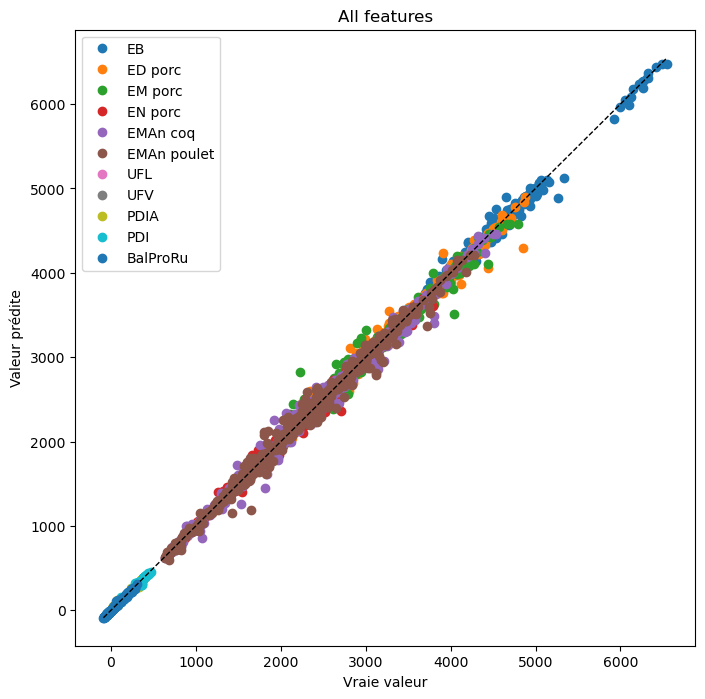

In [151]:
plot_pred_vs_true(models_all, X_test_all, y_test_all, vars_cibles, title="All features", n=0)

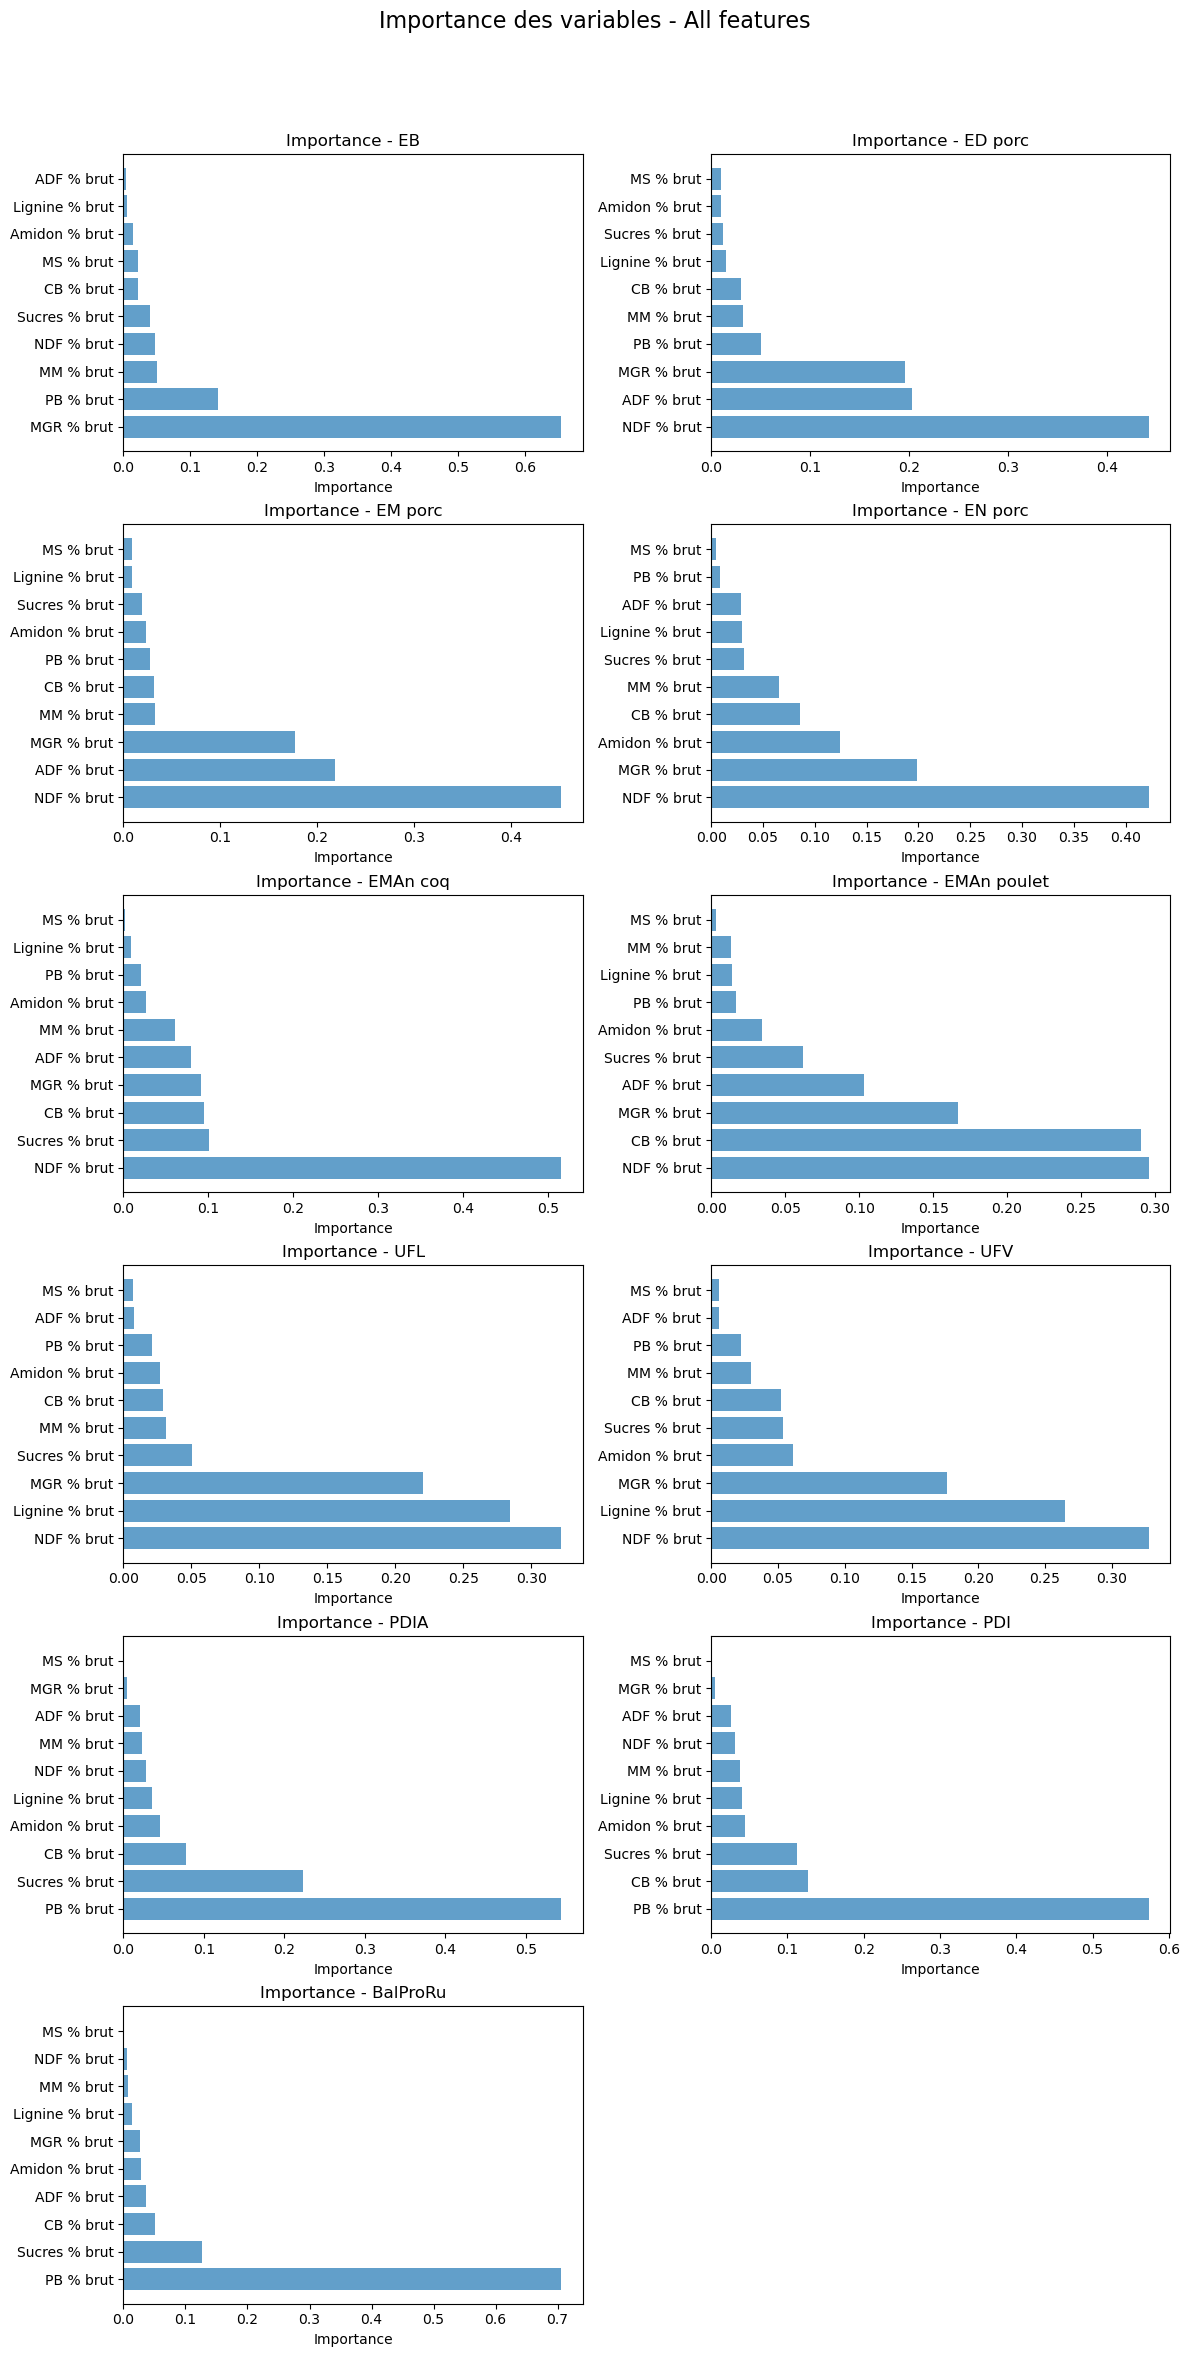

In [152]:
xgb_feature_importances(models_all, X_test_all, vars_expl, title="Importance des variables - All features")

### XGBoost Model | variables explicatives : All features + Classe

In [161]:
# Préparation des données avec split aléatoire
X_train_all_class, X_test_all_class, y_train_all_class, y_test_all_class = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

# Indices pour la feature encodée
indices_train = X_train_all_class.index
indices_test = X_test_all_class.index

# Ajouter la variable Classe encodée
X_train_all_class, X_test_all_class = add_encoded_feature(
    X_train_all_class, X_test_all_class, data, "Classe", indices_train, indices_test
)

# Entraînement des modèles et calcul des métriques
resultats_all_class_df, metrics_all_class, models_all_class = train_xgboost_models(
    X_train_all_class, X_test_all_class, y_train_all, y_test_all, 
    vars_cibles, noms_simplifies, random_state=42
)

print("Résultats du modèle avec All features + Classe encodée :")
print(f"Nombre d'observations en train: {len(X_train_all_class)}")
print(f"Nombre d'observations en test: {len(X_test_all_class)}")
print(resultats_all_class_df.to_string(index=False))
print("\nMétriques globales:")
for key, value in metrics_all_class.items():
    print(f"  {key}: {value}")

Résultats du modèle avec All features + Classe encodée :
Nombre d'observations en train: 3198
Nombre d'observations en test: 800
Variable cible   MAE  RMSE     R2
            EB 23.12 39.93 0.9930
       ED porc 33.96 65.32 0.9887
       EM porc 32.63 55.37 0.9912
       EN porc 23.17 37.20 0.9953
      EMAn coq 35.76 59.09 0.9941
   EMAn poulet 36.40 60.73 0.9935
           UFL  0.01  0.02 0.9870
           UFV  0.01  0.03 0.9860
          PDIA  1.68  4.60 0.9969
           PDI  1.94  5.18 0.9959
      BalProRu  2.25  4.43 0.9977

Métriques globales:
  R2_uniform: 0.9927
  R2_variance_weighted: 0.9928
  R2_min: 0.986


Variable cible  Vraie valeur  Valeur prédite
            EB       3850.00     3838.127930
       ED porc       3370.00     3377.491211
       EM porc       3290.00     3285.867188
       EN porc       2630.00     2652.861328
      EMAn coq       3140.00     3162.116699
   EMAn poulet       3070.00     3108.850098
           UFL          1.11        1.105958
           UFV          1.14        1.141935
          PDIA         34.00       33.736553
           PDI         80.00       79.252998
      BalProRu        -52.00      -51.243374


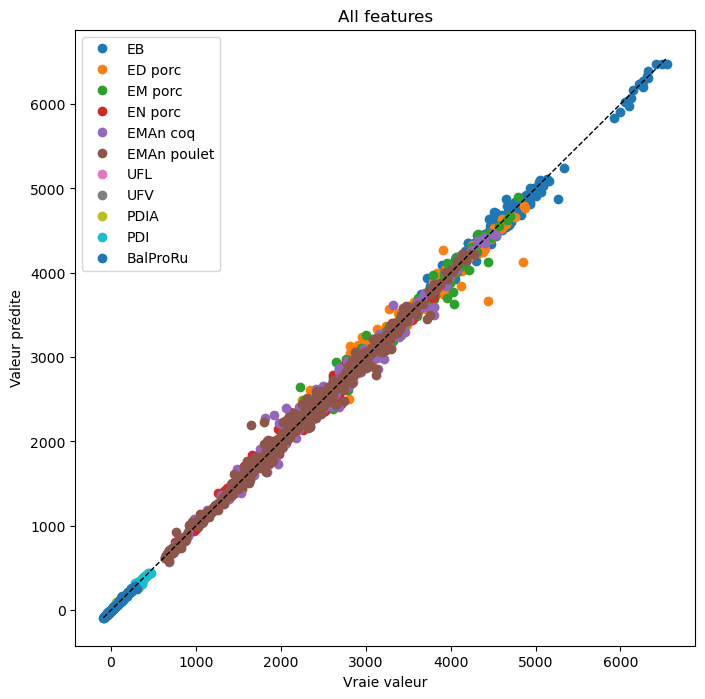

In [154]:
plot_pred_vs_true(models_all_class, X_test_all_class, y_test_all_class, vars_cibles, title="All features", n=0)

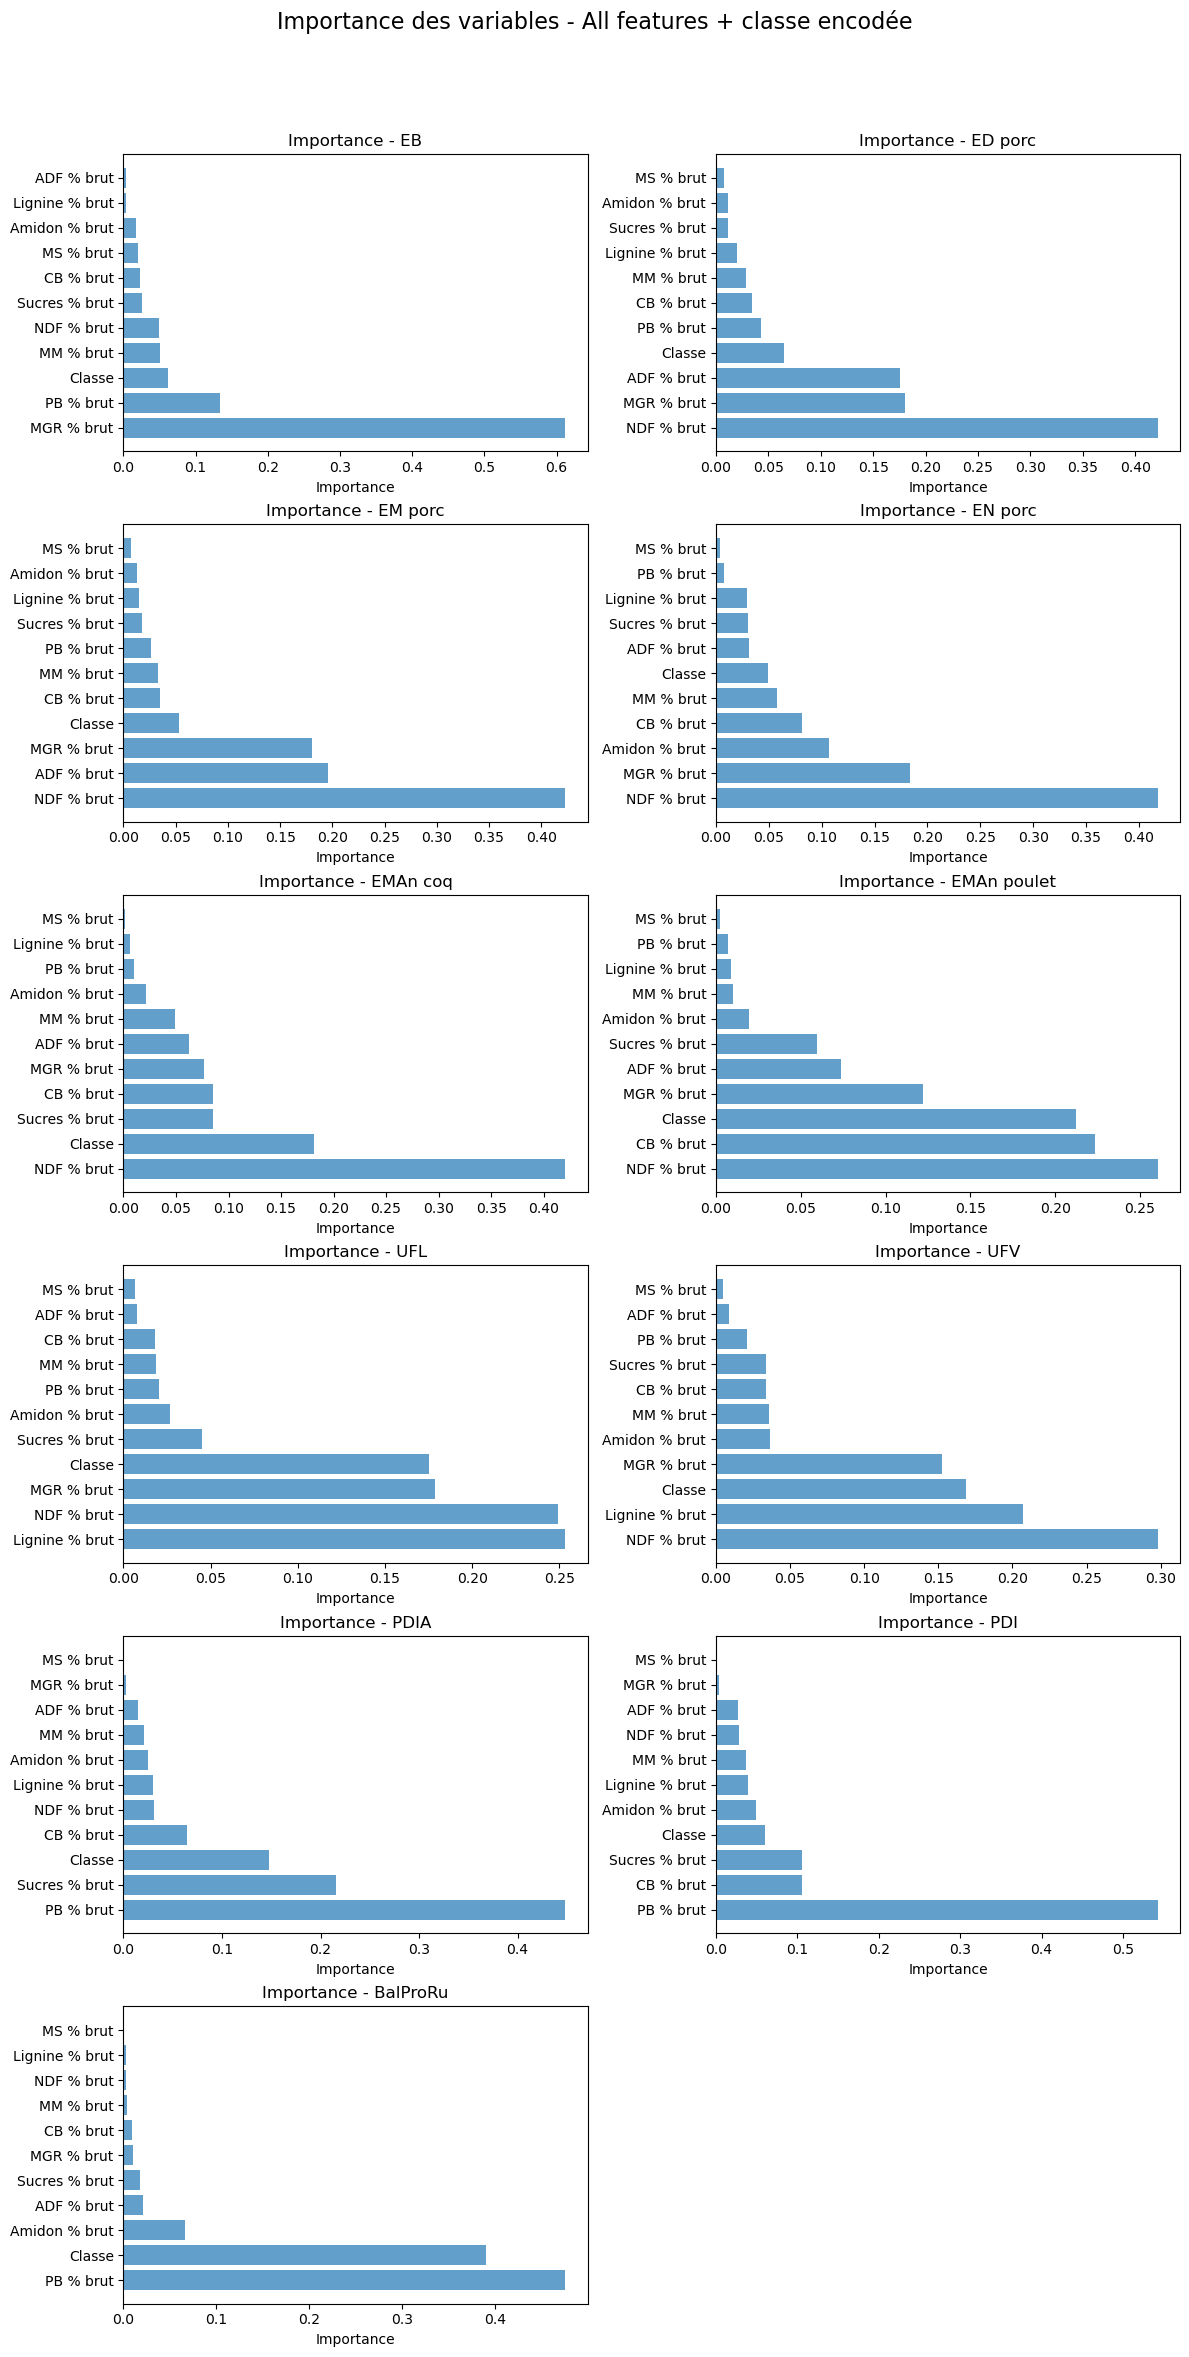

In [159]:
xgb_feature_importances(models_all_class, X_test_all_class, vars_expl + ['Classe'], title="Importance des variables - All features + classe encodée")

### XGBoost Model | variables explicatives : All features + Classe + Nom

In [162]:
# Préparation des données avec split aléatoire
X_train_all_class_nom, X_test_all_class_nom, y_train_all_class_nom, y_test_all_class_nom = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

# Indices pour la feature encodée
indices_train = X_train_all_class_nom.index
indices_test = X_test_all_class_nom.index

# Ajouter la variable Classe encodée
X_train_all_class_nom, X_test_all_class_nom = add_encoded_feature(
    X_train_all_class_nom, X_test_all_class_nom, data, "Classe", indices_train, indices_test
)

# Ajouter la variable Nom encodée
X_train_all_class_nom, X_test_all_class_nom = add_encoded_feature(
    X_train_all_class_nom, X_test_all_class_nom, data, "Nom", indices_train, indices_test
)

# Entraînement des modèles et calcul des métriques
resultats_all_class_nom_df, metrics_all_class_nom, models_all_class_nom = train_xgboost_models(
    X_train_all_class_nom, X_test_all_class_nom, y_train_all_class_nom, y_test_all_class_nom, 
    vars_cibles, noms_simplifies, random_state=42
)

print("Résultats du modèle avec All features + Classe encodée :")
print(f"Nombre d'observations en train: {len(X_train_all_class_nom)}")
print(f"Nombre d'observations en test: {len(X_test_all_class_nom)}")
print(resultats_all_class_nom_df.to_string(index=False))
print("\nMétriques globales:")
for key, value in metrics_all_class_nom.items():
    print(f"  {key}: {value}")

Résultats du modèle avec All features + Classe encodée :
Nombre d'observations en train: 3198
Nombre d'observations en test: 800
Variable cible   MAE  RMSE     R2
            EB 22.61 38.69 0.9935
       ED porc 32.28 56.06 0.9917
       EM porc 31.39 53.78 0.9917
       EN porc 23.05 34.46 0.9960
      EMAn coq 34.95 56.94 0.9946
   EMAn poulet 35.06 58.86 0.9938
           UFL  0.01  0.02 0.9873
           UFV  0.01  0.03 0.9866
          PDIA  1.22  2.62 0.9990
           PDI  1.36  3.08 0.9985
      BalProRu  2.13  4.14 0.9980

Métriques globales:
  R2_uniform: 0.9937
  R2_variance_weighted: 0.9936
  R2_min: 0.9866


Variable cible  Vraie valeur  Valeur prédite
            EB       3850.00     3848.392334
       ED porc       3370.00     3375.665283
       EM porc       3290.00     3279.743408
       EN porc       2630.00     2658.184814
      EMAn coq       3140.00     3167.520508
   EMAn poulet       3070.00     3072.107666
           UFL          1.11        1.106069
           UFV          1.14        1.140251
          PDIA         34.00       33.787804
           PDI         80.00       79.040840
      BalProRu        -52.00      -50.640350


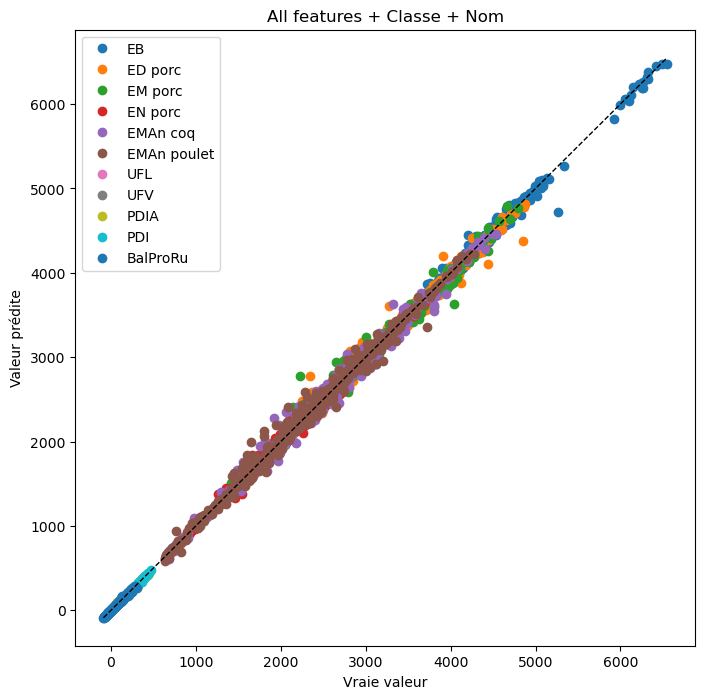

In [163]:
plot_pred_vs_true(models_all_class_nom, X_test_all_class_nom, y_test_all_class_nom, vars_cibles, title="All features + Classe + Nom", n=0)

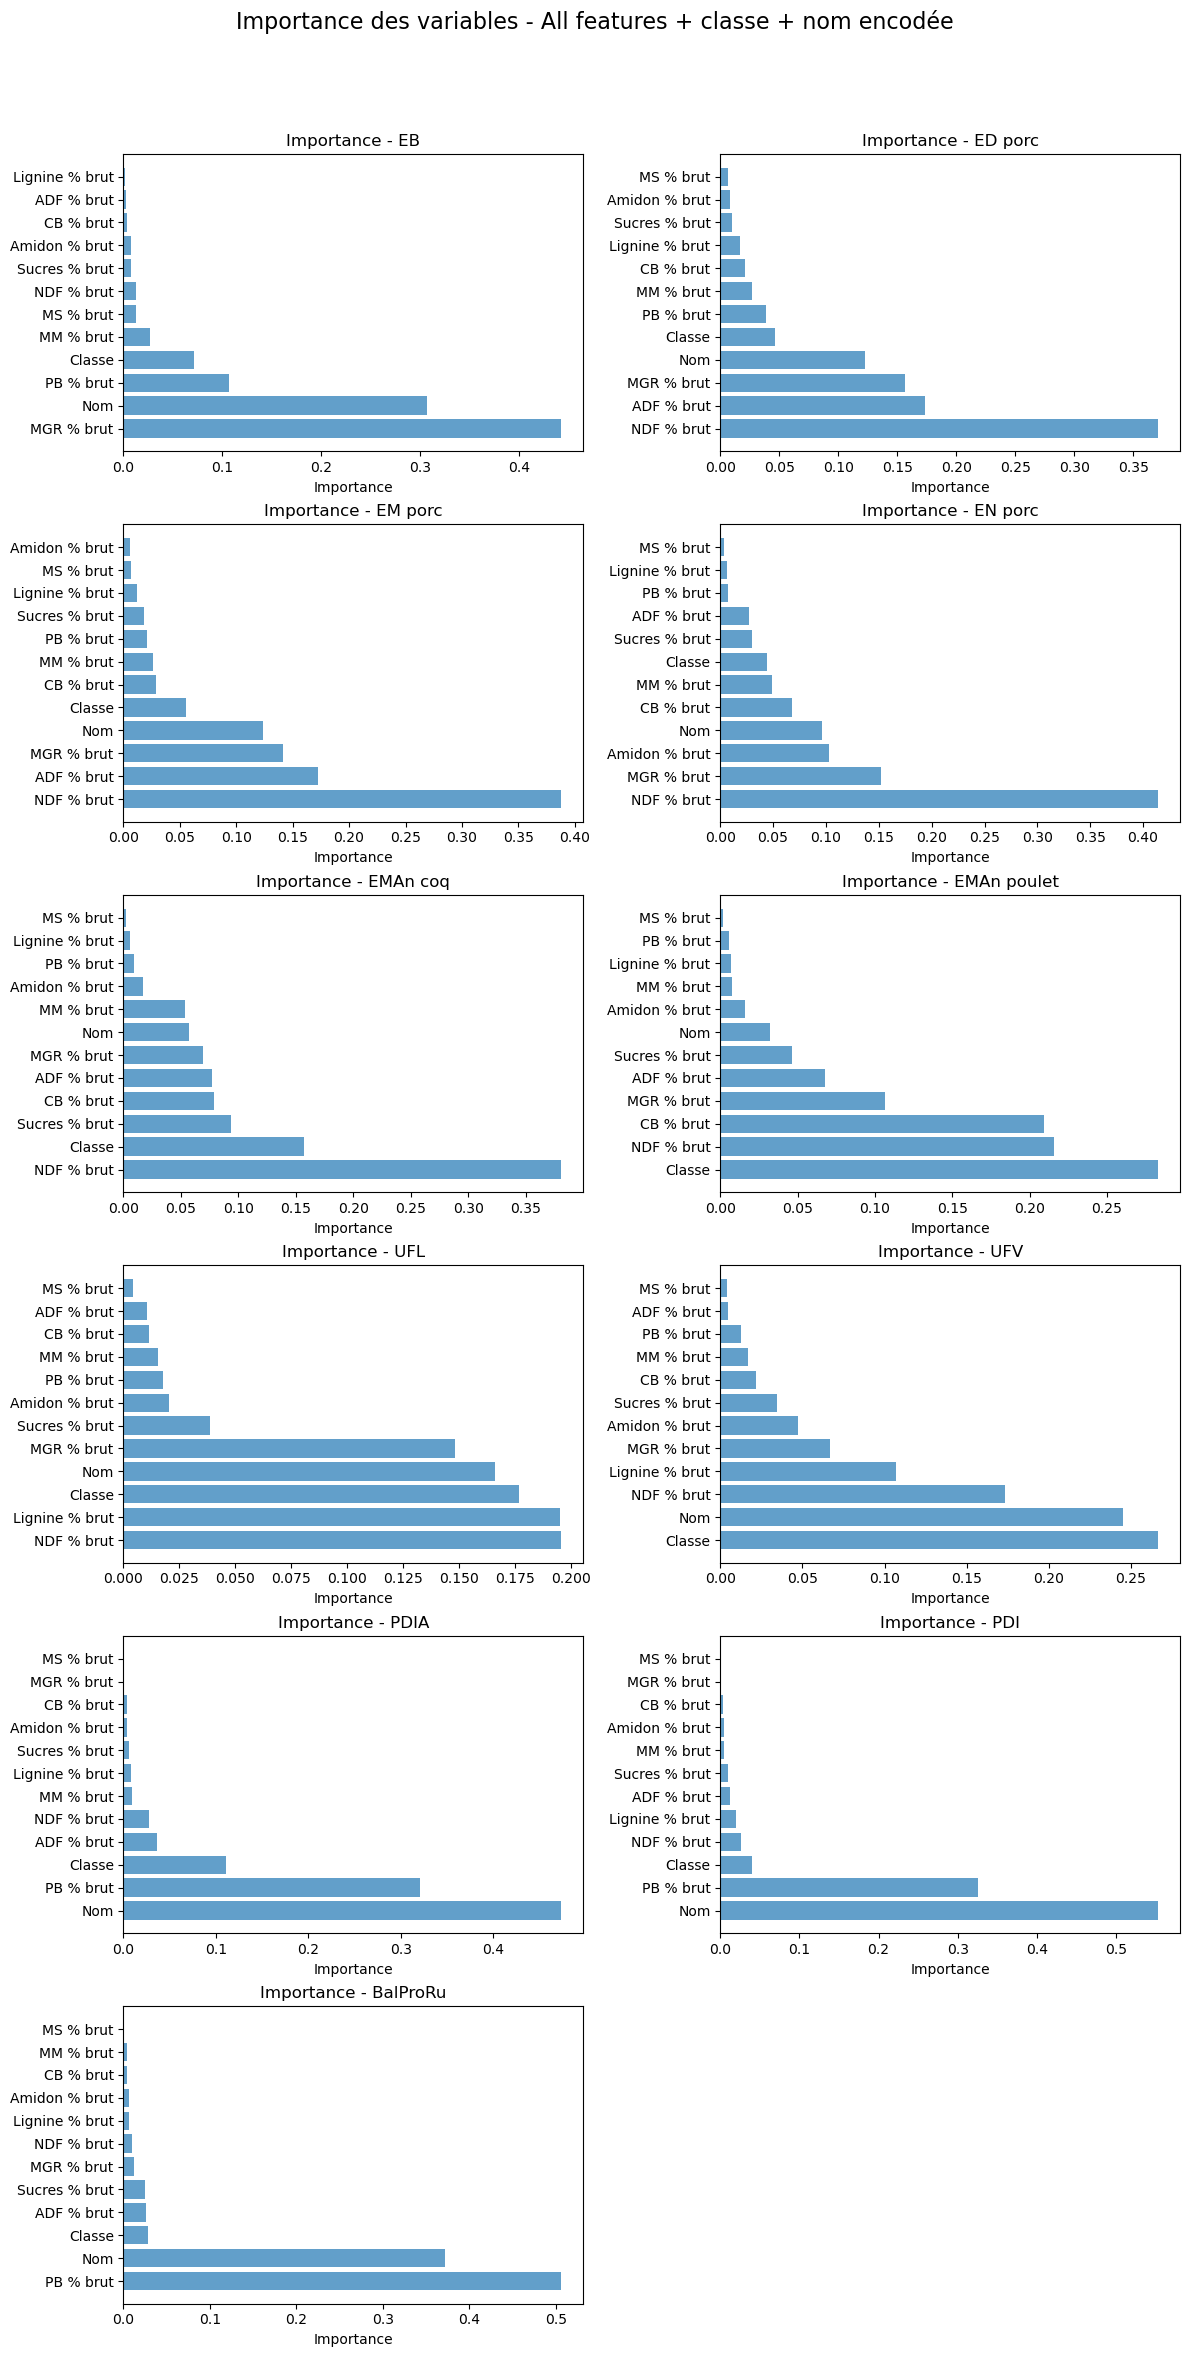

In [164]:
xgb_feature_importances(models_all_class_nom, X_test_all_class_nom, vars_expl + ['Classe', 'Nom'], title="Importance des variables - All features + classe + nom encodée")

### XGBoost Model | variables explicatives : MS % brut & PB % brut

In [90]:
# Sélectionner uniquement les variables explicatives
vars_expl_selected = ["MS % brut", "PB % brut"]

# Préparation des données
X_train, X_test, y_train, y_test = prepare_data_random_split(
    data, vars_expl_selected, vars_cibles, test_size=0.2, random_state=42
)

# Entraînement des modèles
resultats_MS_PB_df, metrics_MS_PB, models_sel = train_xgboost_models(
    X_train, X_test, y_train, y_test, 
    vars_cibles, noms_simplifies, random_state=42
)

print("Résultats du modèle avec MS, PB:")
print(f"Nombre d'observations en train: {len(X_train)}")
print(f"Nombre d'observations en test: {len(X_test)}")
print(resultats_MS_PB_df.to_string(index=False))
print("\nMétriques globales:")
for key, value in metrics_MS_PB.items():
    print(f"  {key}: {value}")

Résultats du modèle avec MS, PB:
Nombre d'observations en train: 3198
Nombre d'observations en test: 800
Variable cible    MAE   RMSE     R2
            EB 180.97 366.77 0.4134
       ED porc 345.08 524.85 0.2722
       EM porc 340.79 518.93 0.2263
       EN porc 325.85 523.88 0.0682
      EMAn coq 425.34 688.55 0.2055
   EMAn poulet 408.15 652.66 0.2436
           UFL   0.11   0.17 0.2411
           UFV   0.13   0.19 0.2214
          PDIA  14.07  27.16 0.8935
           PDI  13.17  25.78 0.8983
      BalProRu  15.26  27.77 0.9111

Métriques globales:
  R2_uniform: 0.4177
  R2_variance_weighted: 0.237
  R2_min: 0.0682


Variable cible  Vraie valeur  Valeur prédite
            EB       3850.00     3781.965820
       ED porc       3370.00     3358.100830
       EM porc       3290.00     3263.253418
       EN porc       2630.00     2479.843506
      EMAn coq       3140.00     3015.965820
   EMAn poulet       3070.00     3042.428711
           UFL          1.11        1.075472
           UFV          1.14        1.089794
          PDIA         34.00       32.676212
           PDI         80.00       78.316849
      BalProRu        -52.00      -49.523315


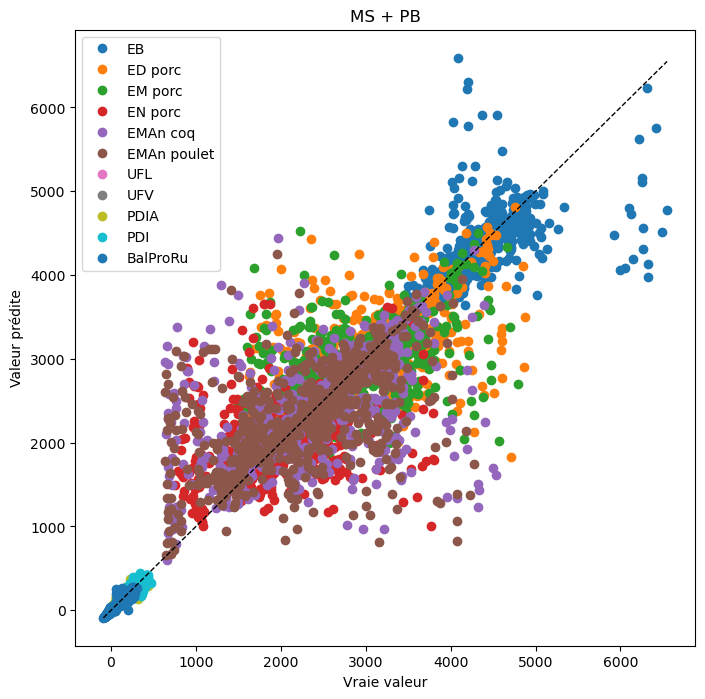

In [92]:
plot_pred_vs_true(models_sel, X_test, y_test, vars_cibles, title="MS + PB", n=0)

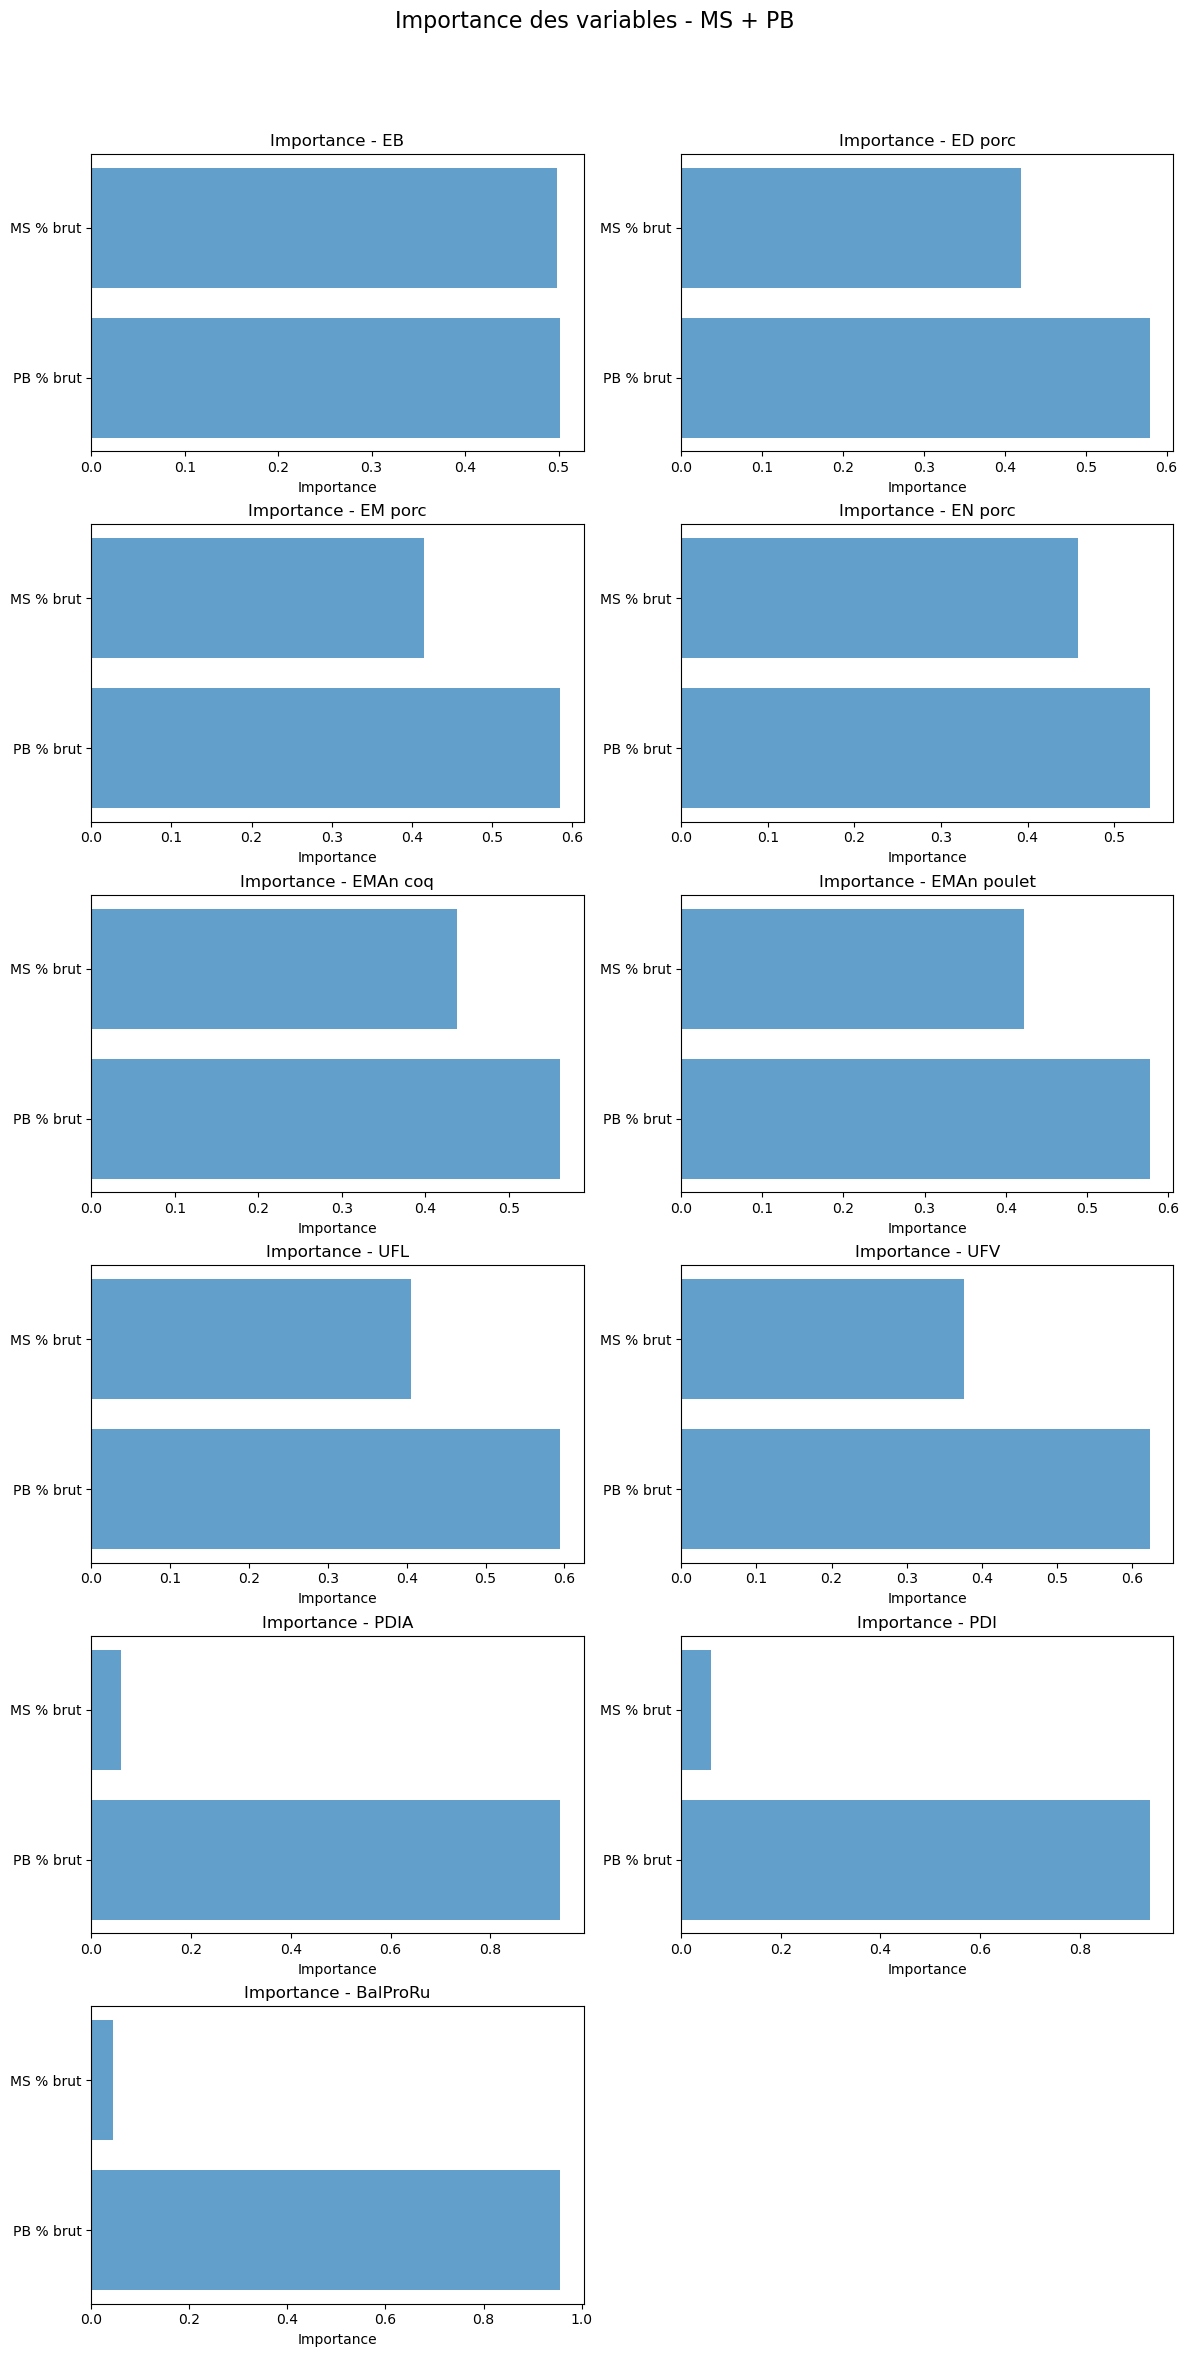

In [93]:
xgb_feature_importances(models_sel, X_test, vars_expl_selected, title="Importance des variables - MS + PB")

### XGBoost Model | variables explicatives : MS % brut & PB % brut & Classe encoded

In [94]:
# Variables explicatives sélectionnées
vars_expl_with_classe = ["MS % brut", "PB % brut"]

# Préparation des données avec split aléatoire
X_train_sel, X_test_sel, y_train_sel, y_test_sel = prepare_data_random_split(
    data, vars_expl_with_classe, vars_cibles, test_size=0.2, random_state=42
)

# Indices pour la feature encodée
indices_train = X_train_sel.index
indices_test = X_test_sel.index

# Ajouter la variable Classe encodée
X_train_sel, X_test_sel = add_encoded_feature(
    X_train_sel, X_test_sel, data, "Classe", indices_train, indices_test
)

# Entraînement des modèles
resultats_MS_PB_Classe_df, metrics_MS_PB_Classe, models_sel_class = train_xgboost_models(
    X_train_sel, X_test_sel, y_train_sel, y_test_sel, 
    vars_cibles, noms_simplifies, random_state=42
)

print("Résultats du modèle avec MS, PB et Classe:")
print(f"Nombre d'observations en train: {len(X_train_sel)}")
print(f"Nombre d'observations en test: {len(X_test_sel)}")
print(resultats_MS_PB_Classe_df.to_string(index=False))
print("\nMétriques globales:")
for key, value in metrics_MS_PB_Classe.items():
    print(f"  {key}: {value}")

Résultats du modèle avec MS, PB et Classe:
Nombre d'observations en train: 3198
Nombre d'observations en test: 800
Variable cible    MAE   RMSE     R2
            EB  80.03 138.15 0.9168
       ED porc 161.60 247.71 0.8379
       EM porc 157.74 245.10 0.8274
       EN porc 140.82 217.58 0.8393
      EMAn coq 164.43 256.08 0.8901
   EMAn poulet 175.74 267.87 0.8726
           UFL   0.05   0.08 0.8463
           UFV   0.06   0.09 0.8338
          PDIA   5.05  11.89 0.9796
           PDI   5.24  12.32 0.9768
      BalProRu   6.07  12.43 0.9822

Métriques globales:
  R2_uniform: 0.8912
  R2_variance_weighted: 0.8661
  R2_min: 0.8274


Variable cible  Vraie valeur  Valeur prédite
            EB       3850.00     3858.773438
       ED porc       3370.00     3401.673584
       EM porc       3290.00     3301.622070
       EN porc       2630.00     2662.760742
      EMAn coq       3140.00     3206.417725
   EMAn poulet       3070.00     3159.104248
           UFL          1.11        1.107623
           UFV          1.14        1.140764
          PDIA         34.00       35.872326
           PDI         80.00       78.103523
      BalProRu        -52.00      -51.187534


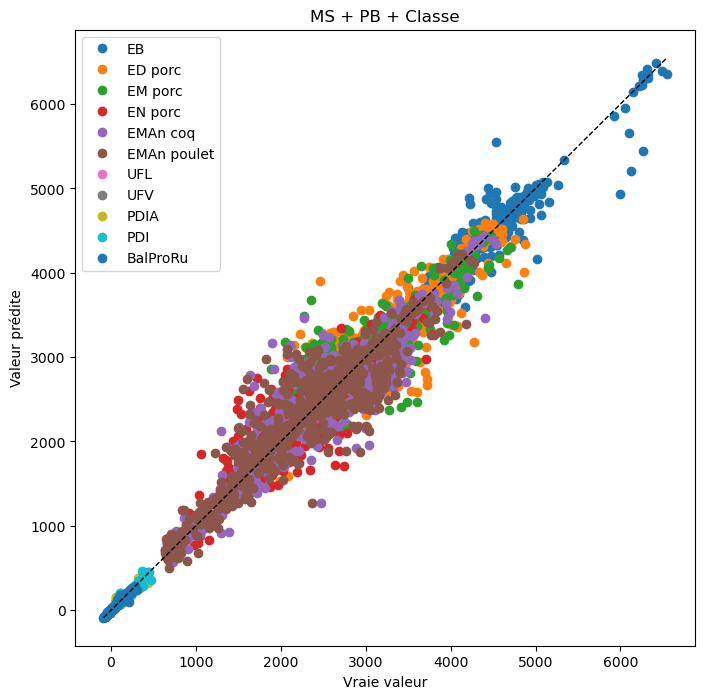

In [95]:
plot_pred_vs_true(models_sel_class, X_test_sel, y_test_sel, vars_cibles, title="MS + PB + Classe", n=0)

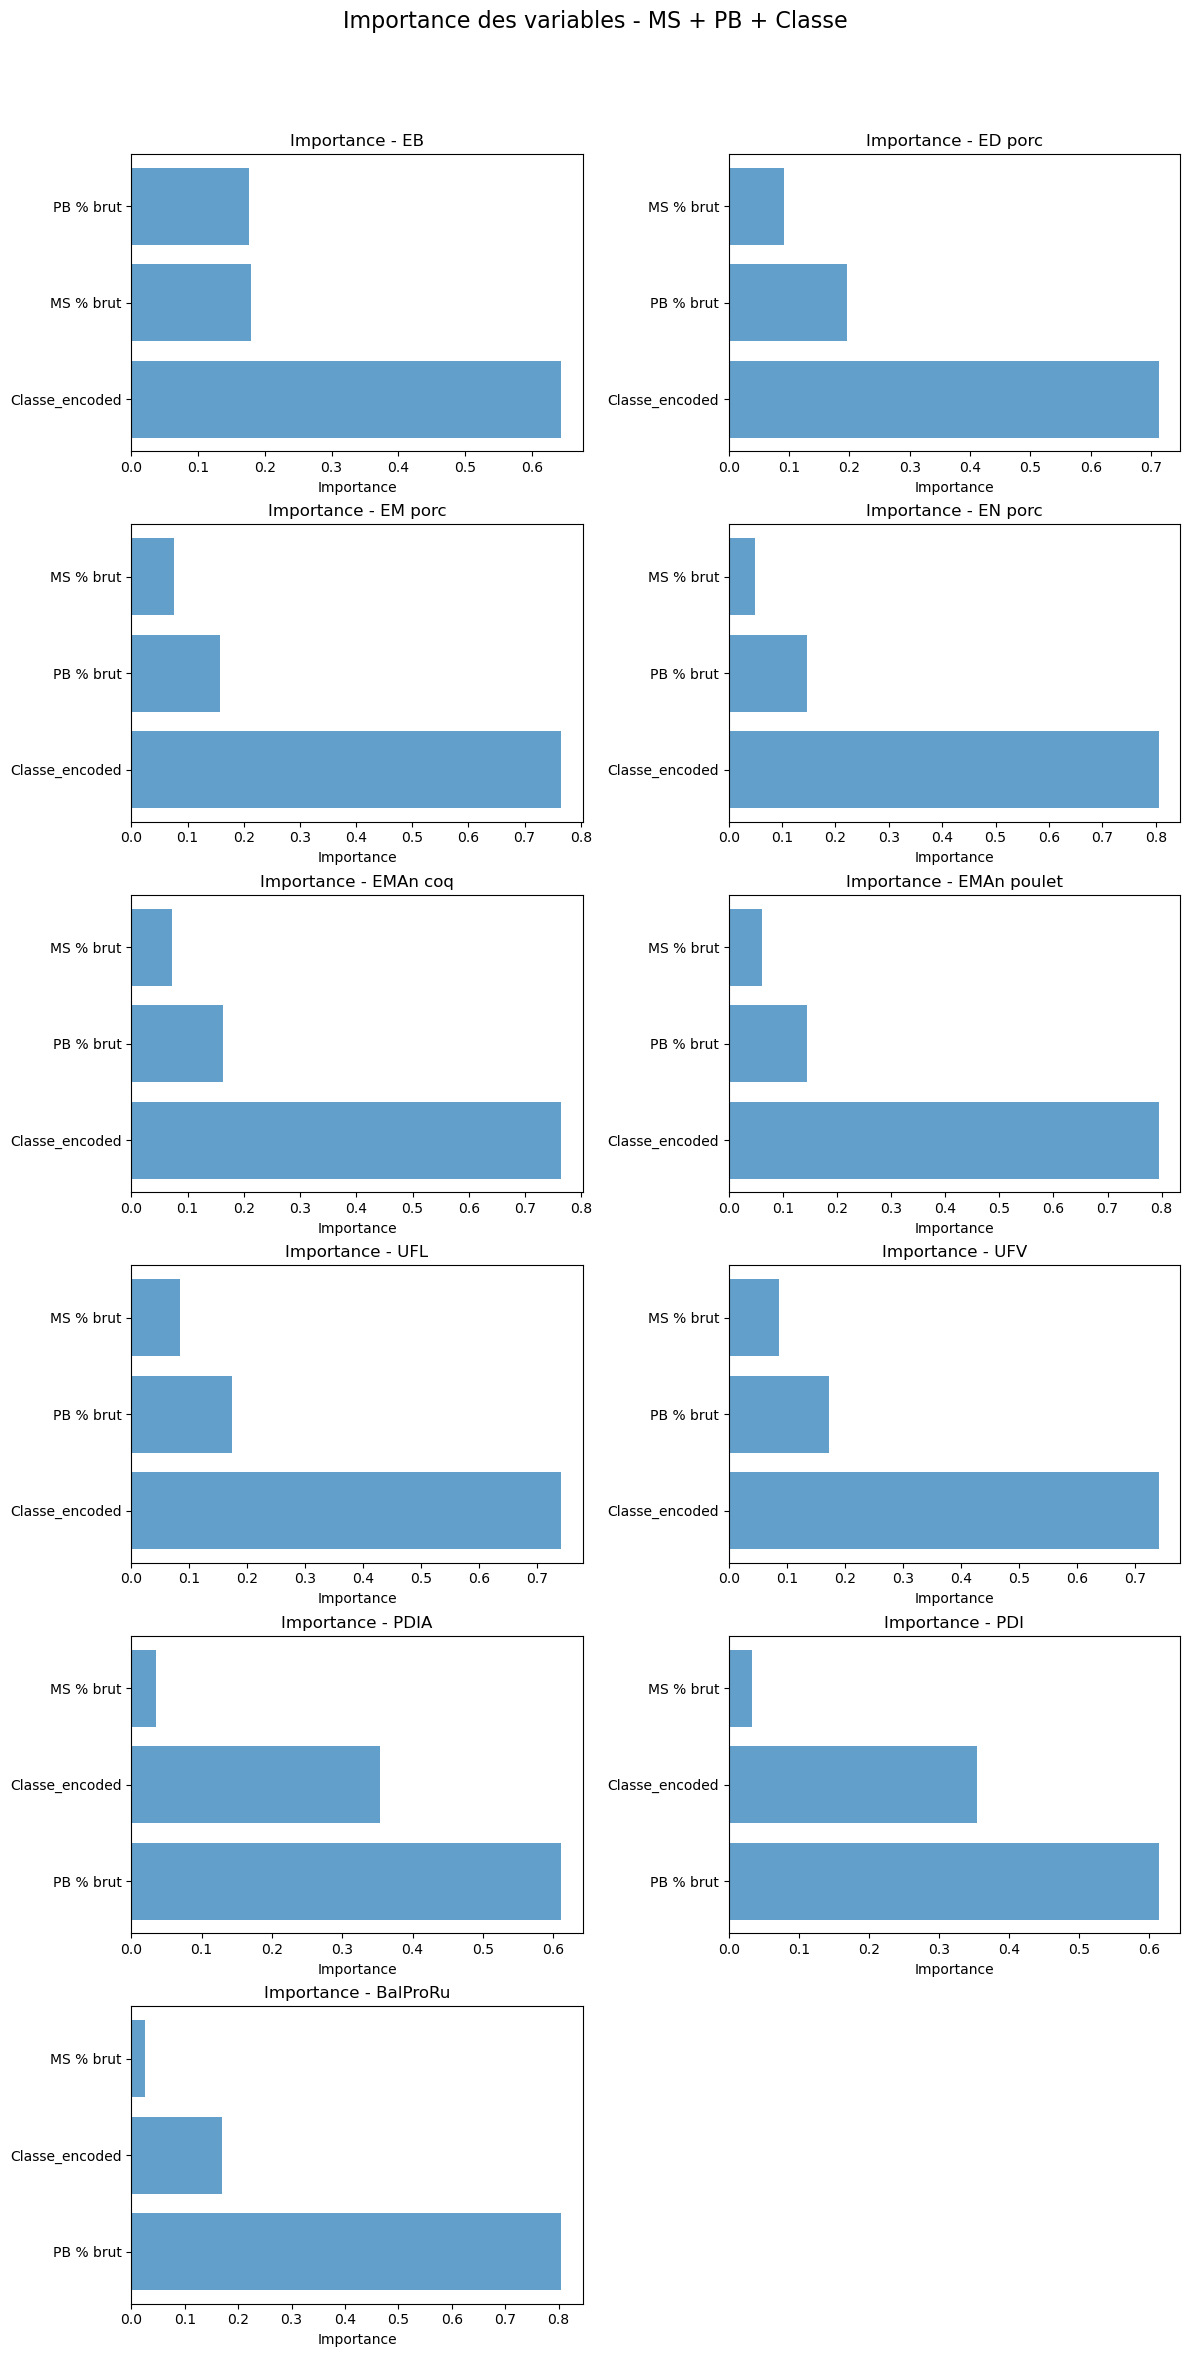

In [96]:
xgb_feature_importances(models_sel_class, X_test_sel, vars_expl_with_classe + ["Classe_encoded"], title="Importance des variables - MS + PB + Classe")

### XGBoost Model | variables explicatives : MS % brut & PB % brut & Classe encoded
### Un Nom par Classe caché à l'entrainement et utilisé en test uniquement pour voir l'impact sur la performance du modèle d'un produit inconnu assimilé à une classe existante.

In [97]:
# Variables explicatives sélectionnées
vars_expl_hide = ["MS % brut", "PB % brut"]

# Préparation des données en cachant 1 produit par classe
X_train_hide, X_test_hide, y_train_hide, y_test_hide, classe_test, nom_test = prepare_data_hide_one_per_class(
    data, vars_expl_hide, vars_cibles, "Classe", random_state=42
)

# Obtenir les indices pour l'ajout de la feature encodée
indices_train_hide = X_train_hide.index
indices_test_hide = X_test_hide.index

# Ajouter la variable Classe encodée
X_train_hide, X_test_hide = add_encoded_feature(
    X_train_hide, X_test_hide, data, "Classe", indices_train_hide, indices_test_hide
)

# Entraînement des modèles
resultats_hide_df, metrics_hide, models_hide_name_class = train_xgboost_models(
    X_train_hide, X_test_hide, y_train_hide, y_test_hide, 
    vars_cibles, noms_simplifies, random_state=42
)

print(f"Nombre d'observations en train: {len(X_train_hide)}")
print(f"Nombre d'observations en test: {len(X_test_hide)}")
print("Résultats du modèle avec MS, PB et Classe:")
print(resultats_hide_df.to_string(index=False))
print("\nMétriques globales:")
for key, value in metrics_hide.items():
    print(f"  {key}: {value}")
print()

display_hidden_products(classe_test, nom_test)
# Afficher les produits cachés à l'entraînement

Nombre d'observations en train: 2882
Nombre d'observations en test: 1116
Résultats du modèle avec MS, PB et Classe:
Variable cible    MAE    RMSE      R2
            EB 316.54  473.06 -0.8315
       ED porc 707.39  920.59 -0.5843
       EM porc 698.27  915.80 -0.6888
       EN porc 696.22  934.85 -1.1583
      EMAn coq 866.18 1119.98 -0.6916
   EMAn poulet 863.07 1181.83 -0.9891
           UFL   0.20    0.27 -1.4385
           UFV   0.21    0.29 -1.0128
          PDIA  36.41   62.20  0.3846
           PDI  35.13   62.36  0.3246
      BalProRu  33.64   54.78  0.7623

Métriques globales:
  R2_uniform: -0.5385
  R2_variance_weighted: -0.799
  R2_min: -1.4385

Produits de test (cachés à l'entraînement):
                                Classe                                                   Nom
                              Céréales                                            Triticale 
              Autres produits végétaux                                       Coques de soja 
        Autr

Variable cible  Vraie valeur  Valeur prédite
            EB       3740.00     4046.820068
       ED porc       3200.00     2906.479492
       EM porc       3100.00     2823.880859
       EN porc       2420.00     2135.733154
      EMAn coq       2890.00     2802.765625
   EMAn poulet       2770.00     2691.242432
           UFL          1.02        0.933638
           UFV          1.03        0.923245
          PDIA         21.00       26.530960
           PDI         75.00       74.523178
      BalProRu        -16.00      -14.514355


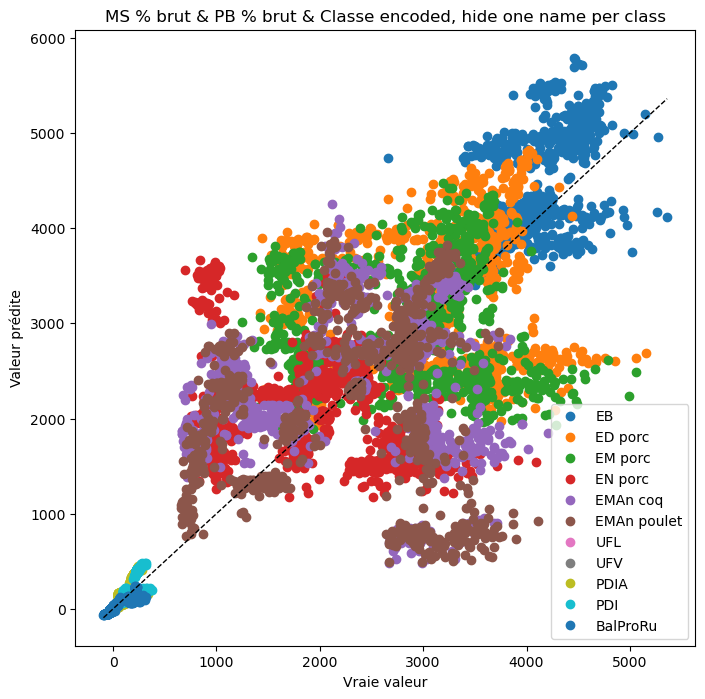

In [98]:
plot_pred_vs_true(models_hide_name_class, X_test_hide, y_test_hide, vars_cibles, title="MS % brut & PB % brut & Classe encoded, hide one name per class", n=0)

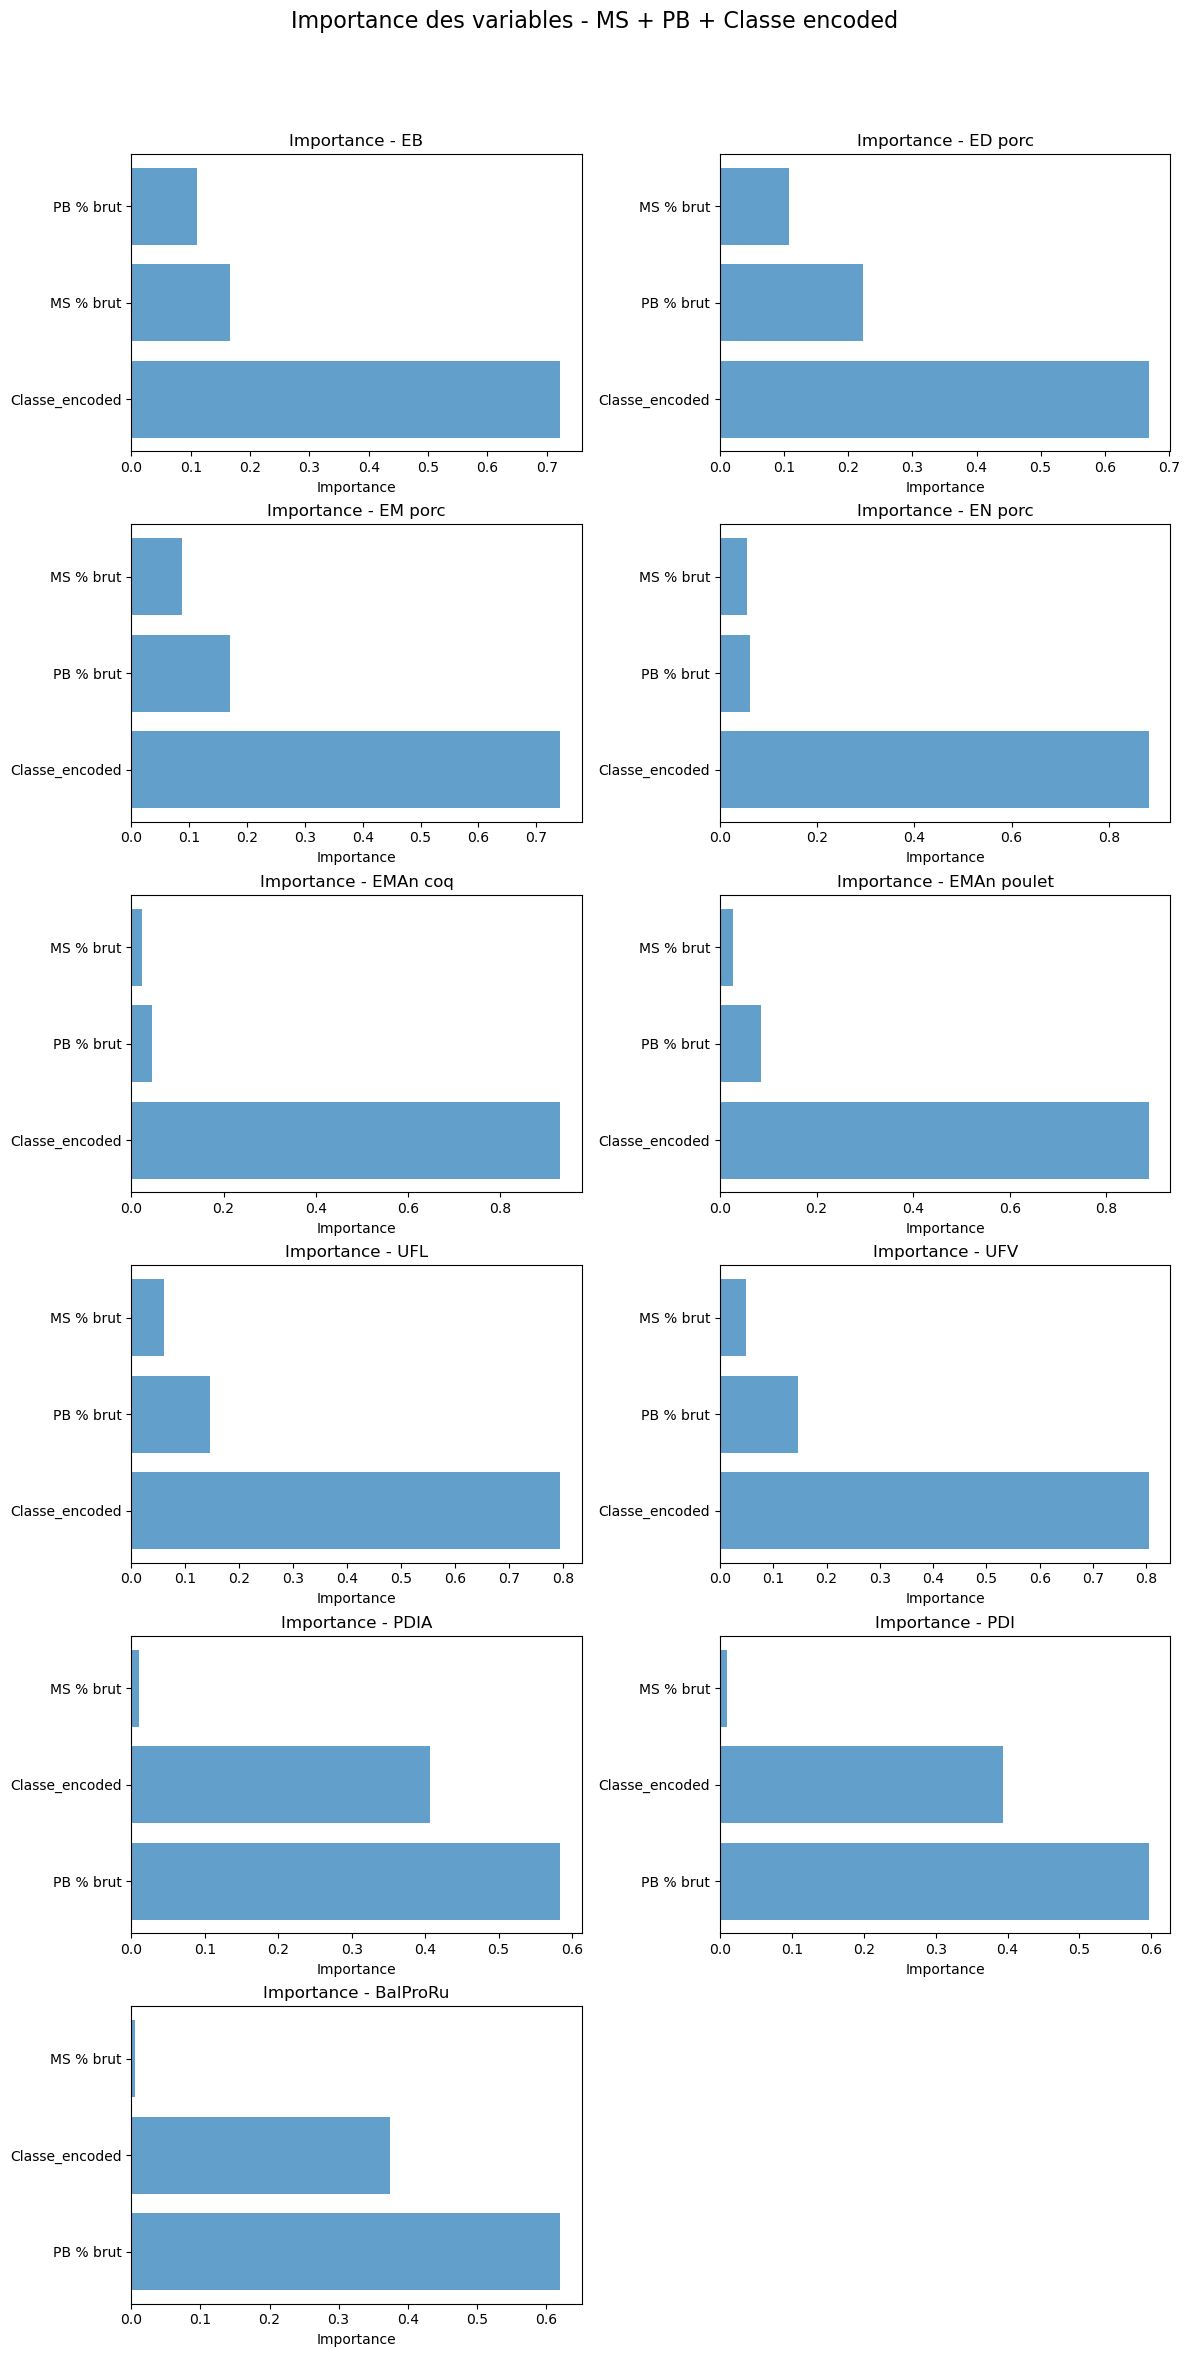

In [99]:
xgb_feature_importances(models_hide_name_class, X_test_hide, vars_expl_hide + ["Classe_encoded"], title="Importance des variables - MS + PB + Classe encoded")

### XGBoost Model | variables explicatives : MS % brut & PB % brut & Classe & Nom encoded

In [100]:
# Variables explicatives sélectionnées
vars_expl_with_classe_nom = ["MS % brut", "PB % brut"]

# Préparation des données avec split aléatoire
X_train_sel_nom, X_test_sel_nom, y_train_sel_nom, y_test_sel_nom = prepare_data_random_split(
    data, vars_expl_with_classe_nom, vars_cibles, test_size=0.2, random_state=42
)

# Indices pour les features encodées
indices_train_nom = X_train_sel_nom.index
indices_test_nom = X_test_sel_nom.index

# Ajouter la variable Classe encodée
X_train_sel_nom, X_test_sel_nom = add_encoded_feature(
    X_train_sel_nom, X_test_sel_nom, data, "Classe", indices_train_nom, indices_test_nom
)

# Ajouter la variable Nom encodée
X_train_sel_nom, X_test_sel_nom = add_encoded_feature(
    X_train_sel_nom, X_test_sel_nom, data, "Nom", indices_train_nom, indices_test_nom
)

# Entraînement des modèles
resultats_MS_PB_Classe_Nom_df, metrics_MS_PB_Classe_Nom, models_sel_class_nom = train_xgboost_models(
    X_train_sel_nom, X_test_sel_nom, y_train_sel_nom, y_test_sel_nom, 
    vars_cibles, noms_simplifies, random_state=42
)

print("Résultats du modèle avec MS, PB, Classe et Nom encodés:")
print(f"Nombre d'observations en train: {len(X_train_sel_nom)}")
print(f"Nombre d'observations en test: {len(X_test_sel_nom)}")
print(resultats_MS_PB_Classe_Nom_df.to_string(index=False))
print("\nMétriques globales:")
for key, value in metrics_MS_PB_Classe_Nom.items():
    print(f"  {key}: {value}")

Résultats du modèle avec MS, PB, Classe et Nom encodés:
Nombre d'observations en train: 3198
Nombre d'observations en test: 800
Variable cible   MAE   RMSE     R2
            EB 50.37  87.16 0.9669
       ED porc 90.57 144.44 0.9449
       EM porc 87.87 140.20 0.9435
       EN porc 74.36 114.92 0.9552
      EMAn coq 88.25 137.68 0.9682
   EMAn poulet 82.89 132.23 0.9690
           UFL  0.03   0.05 0.9423
           UFV  0.03   0.06 0.9362
          PDIA  0.93   2.02 0.9994
           PDI  1.31   2.49 0.9991
      BalProRu  1.86   3.10 0.9989

Métriques globales:
  R2_uniform: 0.9658
  R2_variance_weighted: 0.9598
  R2_min: 0.9362


Variable cible  Vraie valeur  Valeur prédite
            EB       3850.00     3856.839111
       ED porc       3370.00     3365.944092
       EM porc       3290.00     3278.152100
       EN porc       2630.00     2653.562500
      EMAn coq       3140.00     3198.978271
   EMAn poulet       3070.00     3129.009277
           UFL          1.11        1.109893
           UFV          1.14        1.136354
          PDIA         34.00       33.716267
           PDI         80.00       79.119202
      BalProRu        -52.00      -50.459061


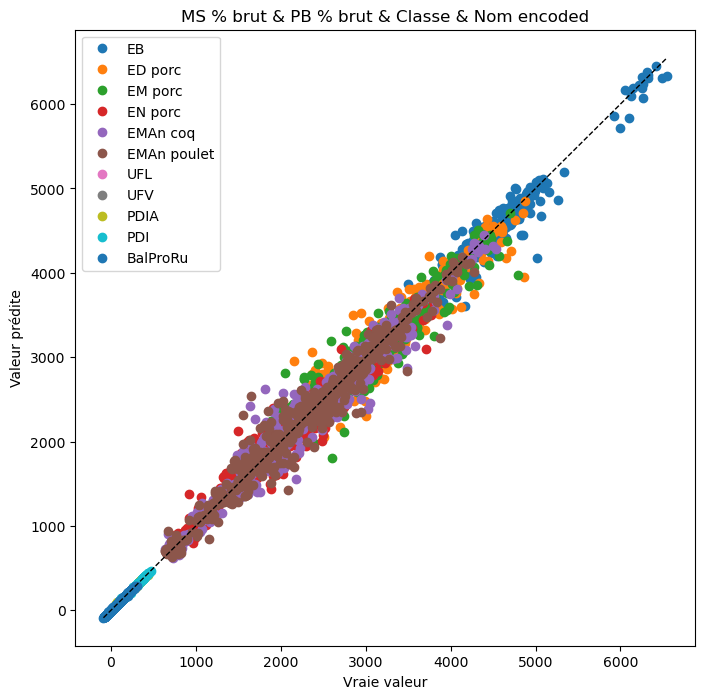

In [101]:
plot_pred_vs_true(models_sel_class_nom, X_test_sel_nom, y_test_sel_nom, vars_cibles, title="MS % brut & PB % brut & Classe & Nom encoded", n=0)

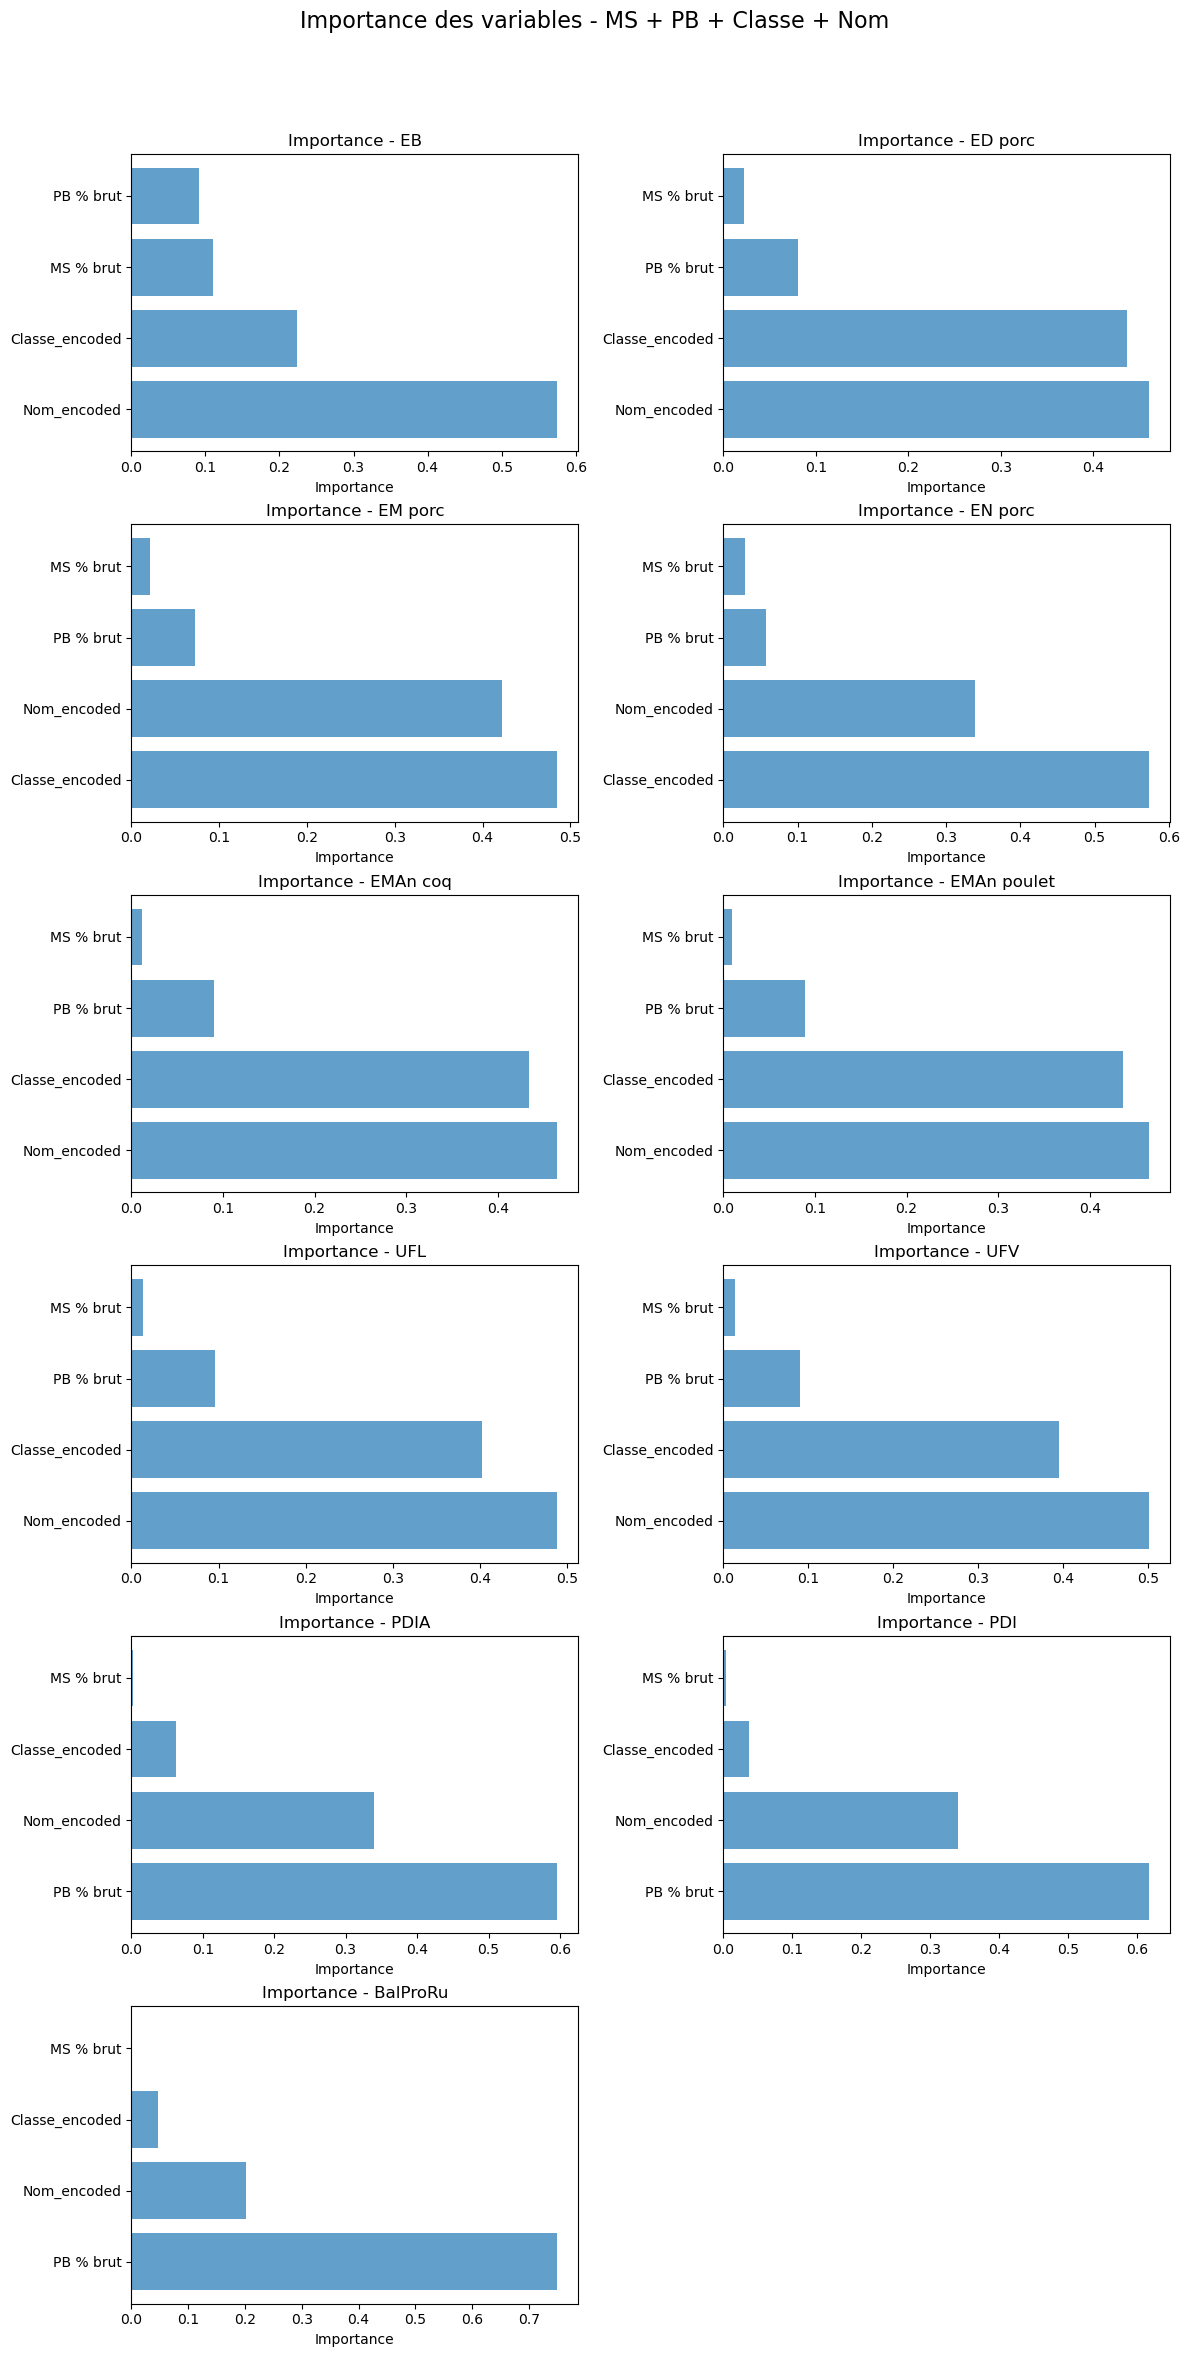

In [102]:
xgb_feature_importances(models_sel_class_nom, X_test_sel_nom, vars_expl_with_classe_nom + ["Classe_encoded", "Nom_encoded"], title="Importance des variables - MS + PB + Classe + Nom")

### XGBoost Model | variables explicatives : All features & Classe encoded
### Un Nom par Classe caché à l'entrainement et utilisé en test uniquement pour voir l'impact sur la performance du modèle d'un produit inconnu assimilé à une classe existante.

In [103]:
# Préparation des données en cachant 1 produit par classe
X_train_hide_all, X_test_hide_all, y_train_hide_all, y_test_hide_all, classe_test_all, nom_test_all = prepare_data_hide_one_per_class(
    data, vars_expl, vars_cibles, "Classe", random_state=42
)

# Obtenir les indices pour l'ajout de la feature encodée
indices_train_hide_all = X_train_hide_all.index
indices_test_hide_all = X_test_hide_all.index

# Ajouter la variable Classe encodée
X_train_hide_all, X_test_hide_all = add_encoded_feature(
    X_train_hide_all, X_test_hide_all, data, "Classe", indices_train_hide_all, indices_test_hide_all
)

# Entraînement des modèles
resultats_hide_all_df, metrics_hide_all, models_hide_all_name_class = train_xgboost_models(
    X_train_hide_all, X_test_hide_all, y_train_hide_all, y_test_hide_all,
    vars_cibles, noms_simplifies, random_state=42
)

print(f"Nombre d'observations en train: {len(X_train_hide_all)}")
print(f"Nombre d'observations en test: {len(X_test_hide_all)}")
print("Résultats du modèle avec All features et Classe:")
print(resultats_hide_all_df.to_string(index=False))
print("\nMétriques globales:")
for key, value in metrics_hide_all.items():
    print(f"  {key}: {value}")
print()

display_hidden_products(classe_test_all, nom_test_all)
# Afficher les produits cachés à l'entraînement

Nombre d'observations en train: 2882
Nombre d'observations en test: 1116
Résultats du modèle avec All features et Classe:
Variable cible    MAE   RMSE      R2
            EB 197.44 321.48  0.1541
       ED porc 307.18 515.26  0.5037
       EM porc 281.98 508.14  0.4801
       EN porc 184.78 284.58  0.8000
      EMAn coq 314.82 394.15  0.7905
   EMAn poulet 370.94 477.27  0.6756
           UFL   0.14   0.21 -0.4028
           UFV   0.14   0.20  0.0524
          PDIA  36.61  65.84  0.3105
           PDI  35.30  63.86  0.2918
      BalProRu  35.61  58.22  0.7315

Métriques globales:
  R2_uniform: 0.3989
  R2_variance_weighted: 0.6356
  R2_min: -0.4028

Produits de test (cachés à l'entraînement):
                                Classe                                                   Nom
                              Céréales                                            Triticale 
              Autres produits végétaux                                       Coques de soja 
        Autres copr

Variable cible  Vraie valeur  Valeur prédite
            EB       3740.00     3759.771729
       ED porc       3200.00     3228.574463
       EM porc       3100.00     3124.277588
       EN porc       2420.00     2420.439941
      EMAn coq       2890.00     2793.689453
   EMAn poulet       2770.00     2404.490723
           UFL          1.02        1.030980
           UFV          1.03        1.041341
          PDIA         21.00       20.355135
           PDI         75.00       74.816467
      BalProRu        -16.00      -15.925352


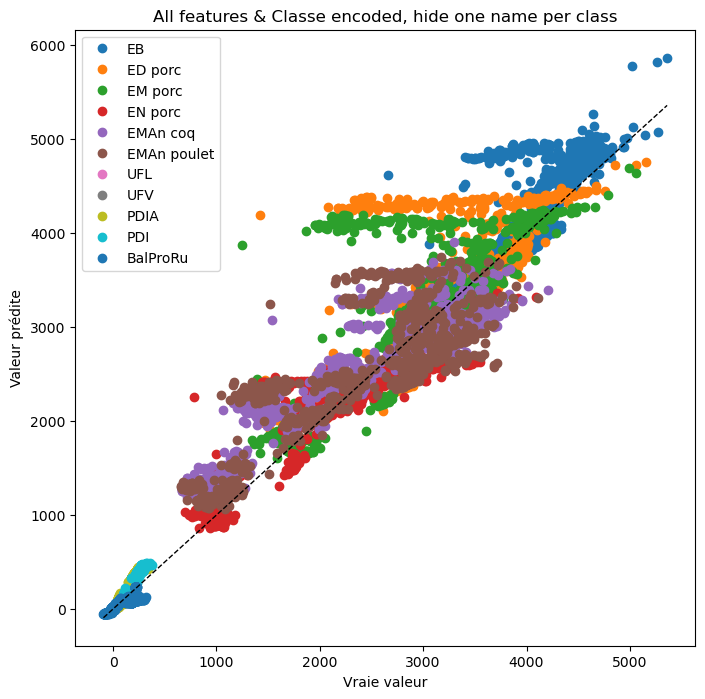

In [104]:
plot_pred_vs_true(models_hide_all_name_class, X_test_hide_all, y_test_hide_all, vars_cibles, title="All features & Classe encoded, hide one name per class", n=0)

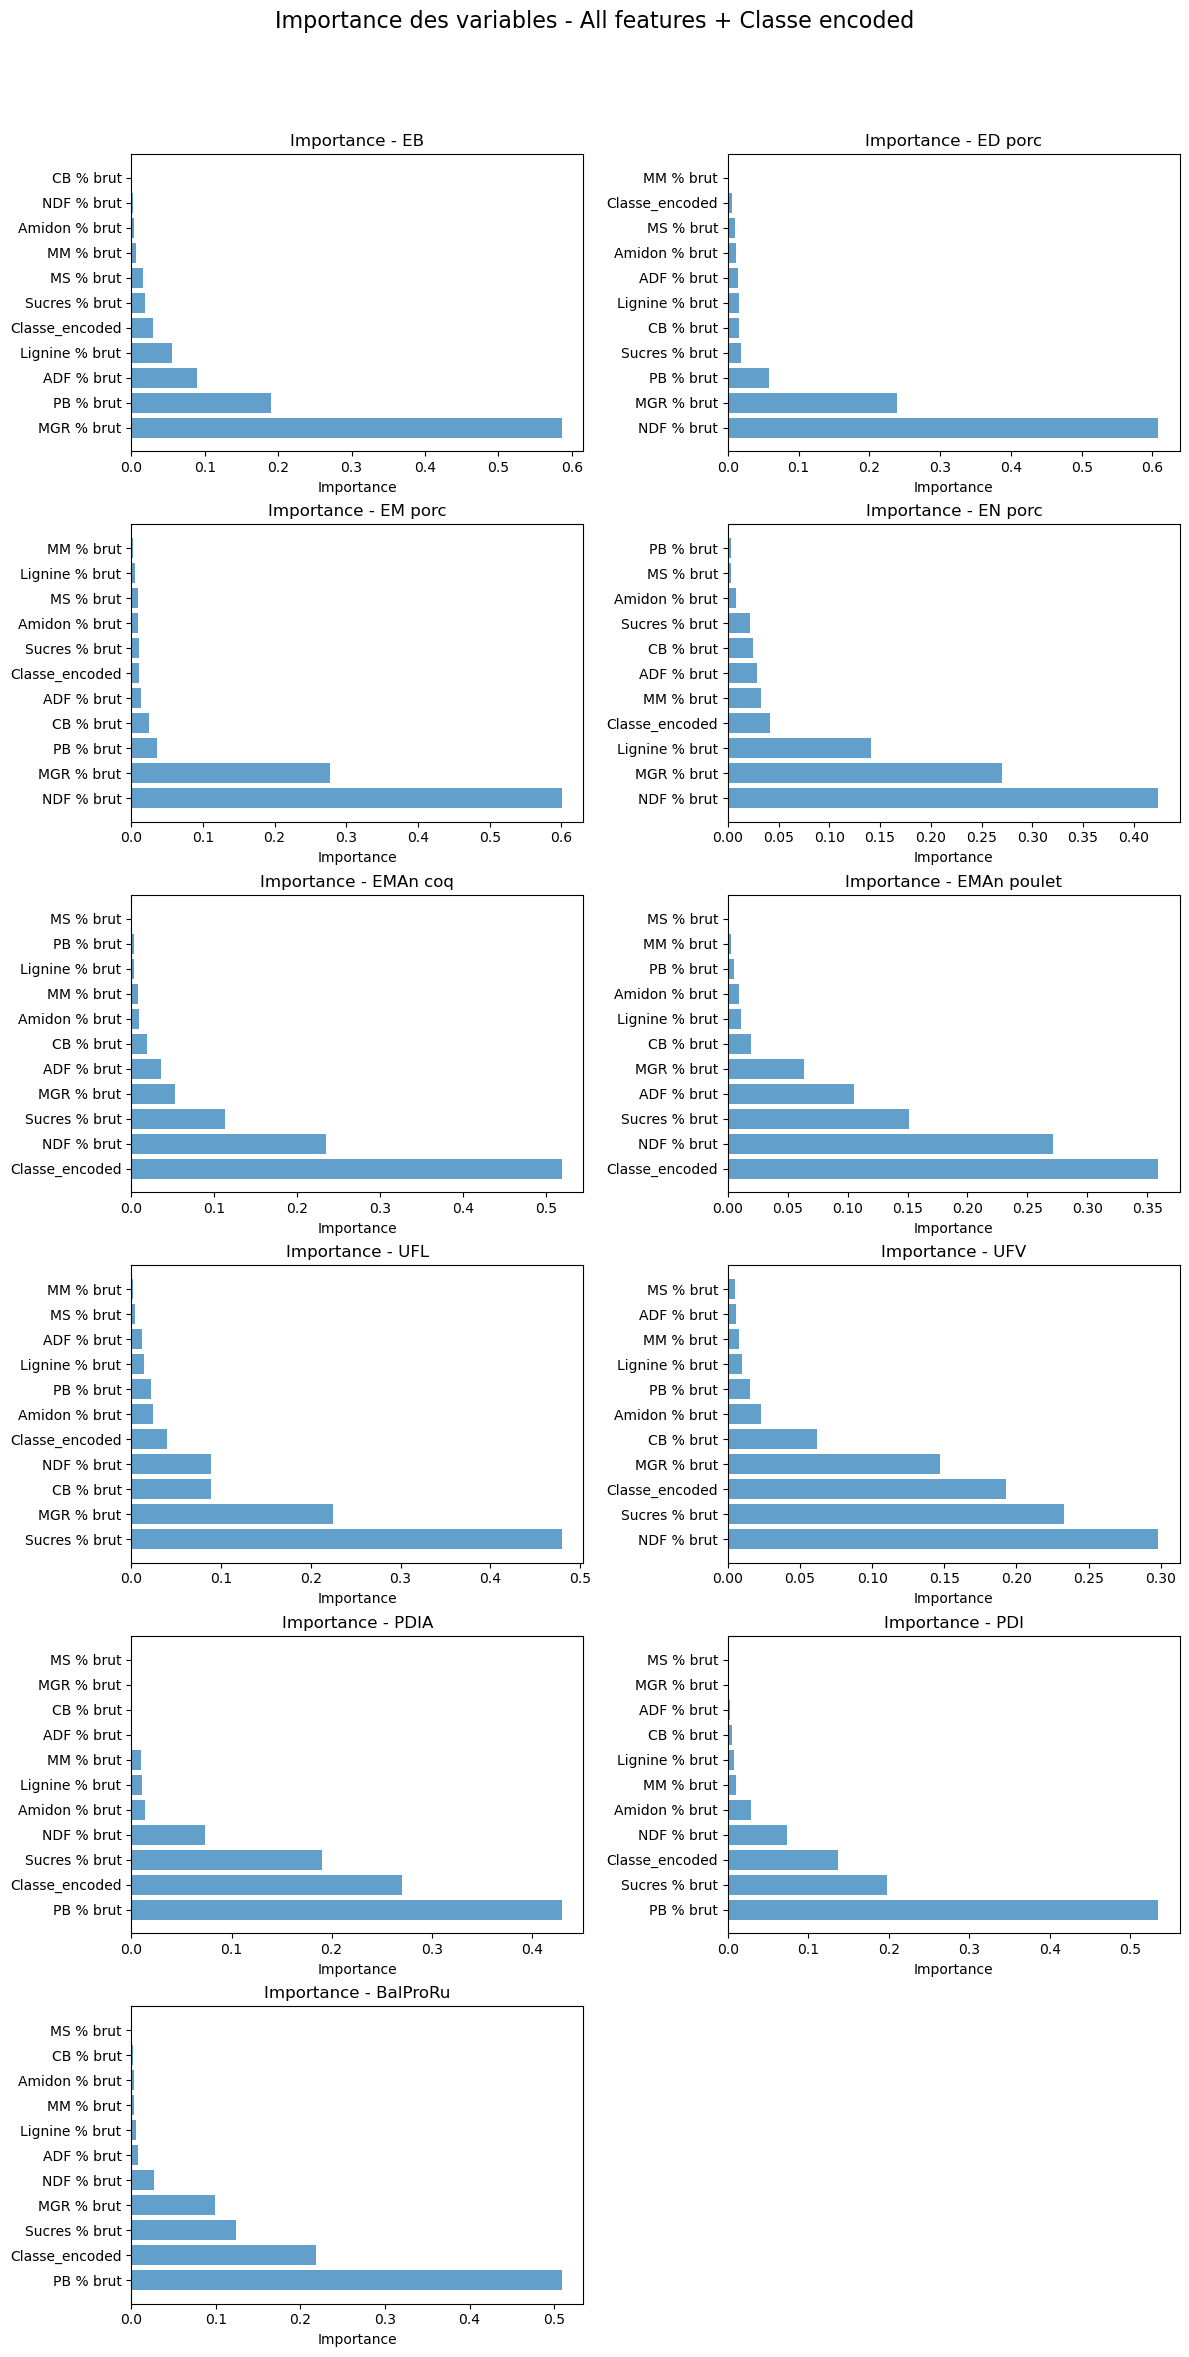

In [105]:
xgb_feature_importances(models_hide_all_name_class, X_test_hide_all, vars_expl + ["Classe_encoded"], title="Importance des variables - All features + Classe encoded")

### XGBoost Model | variables explicatives : MS % brut & PB % brut
### Une Classe cachée à l'entrainement et utilisée en test uniquement pour voir l'impact sur la performance du modèle d'une nouvelle classe inconnue.

In [139]:
# Variables explicatives sélectionnées
vars_expl_hide_class = ["MS % brut", "PB % brut"]

# Préparer les données en masquant une classe entière
# Sélectionner une classe à masquer (première classe par ordre d'apparition)
classe_a_masquer = data['Classe'].unique()[0]

# Indices train et test
indices_train_class = data[data['Classe'] != classe_a_masquer].index
indices_test_class = data[data['Classe'] == classe_a_masquer].index

X_train_class_sel = data.loc[indices_train_class, vars_expl_hide_class].copy()
y_train_class_sel = data.loc[indices_train_class, vars_cibles].copy()

X_test_class_sel = data.loc[indices_test_class, vars_expl_hide_class].copy()
y_test_class_sel = data.loc[indices_test_class, vars_cibles].copy()

# Entraînement des modèles (SANS ajouter la classe encodée)
resultats_hide_class_sel_df, metrics_hide_class_sel, models_hide_class_sel = train_xgboost_models(
    X_train_class_sel, X_test_class_sel, y_train_class_sel, y_test_class_sel, 
    vars_cibles, noms_simplifies, random_state=42
)

print(f"Classe masquée à l'entraînement: {classe_a_masquer}")
print(f"Nombre d'observations en train: {len(X_train_class_sel)}")
print(f"Nombre d'observations en test: {len(X_test_class_sel)}")
print()
print("Résultats du modèle avec classe entière masquée:")
print(resultats_hide_class_sel_df.to_string(index=False))
print("\nMétriques globales:")
for key, value in metrics_hide_class_sel.items():
    print(f"  {key}: {value}")

Classe masquée à l'entraînement: Céréales
Nombre d'observations en train: 3308
Nombre d'observations en test: 690

Résultats du modèle avec classe entière masquée:
Variable cible     MAE    RMSE       R2
            EB  169.48  202.37  -1.3766
       ED porc  596.46  722.86  -7.6713
       EM porc  614.71  730.59  -7.6243
       EN porc  726.98  847.76 -12.3614
      EMAn coq 1247.64 1444.09 -24.2486
   EMAn poulet 1216.82 1435.51 -16.9416
           UFL    0.09    0.11  -1.2517
           UFV    0.11    0.14  -1.2149
          PDIA    9.09   10.43  -0.5208
           PDI    7.02    8.81  -0.9339
      BalProRu    9.21   11.45   0.3578

Métriques globales:
  R2_uniform: -6.7079
  R2_variance_weighted: -14.2514
  R2_min: -24.2486


Variable cible  Vraie valeur  Valeur prédite
            EB       3920.00     3825.706299
       ED porc       2460.00     2300.963379
       EM porc       2380.00     2086.502930
       EN porc       1850.00     1627.842285
      EMAn coq       2610.00     1827.769409
   EMAn poulet       2480.00     1543.289429
           UFL          0.81        0.964765
           UFV          0.76        0.960407
          PDIA         17.00       27.263166
           PDI         62.00       78.141777
      BalProRu        -10.00      -29.946369


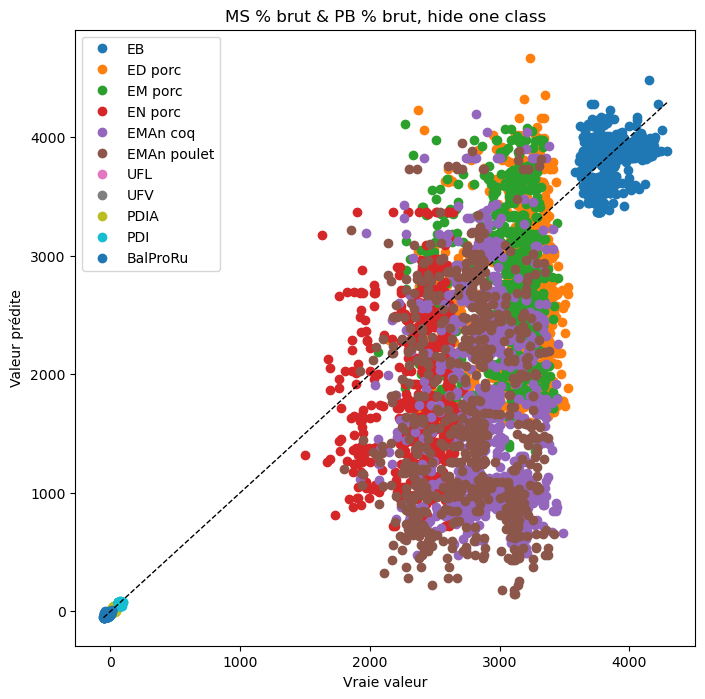

In [141]:
plot_pred_vs_true(models_hide_class_sel, X_test_class_sel, y_test_class, vars_cibles, title="MS % brut & PB % brut, hide one class", n=0)

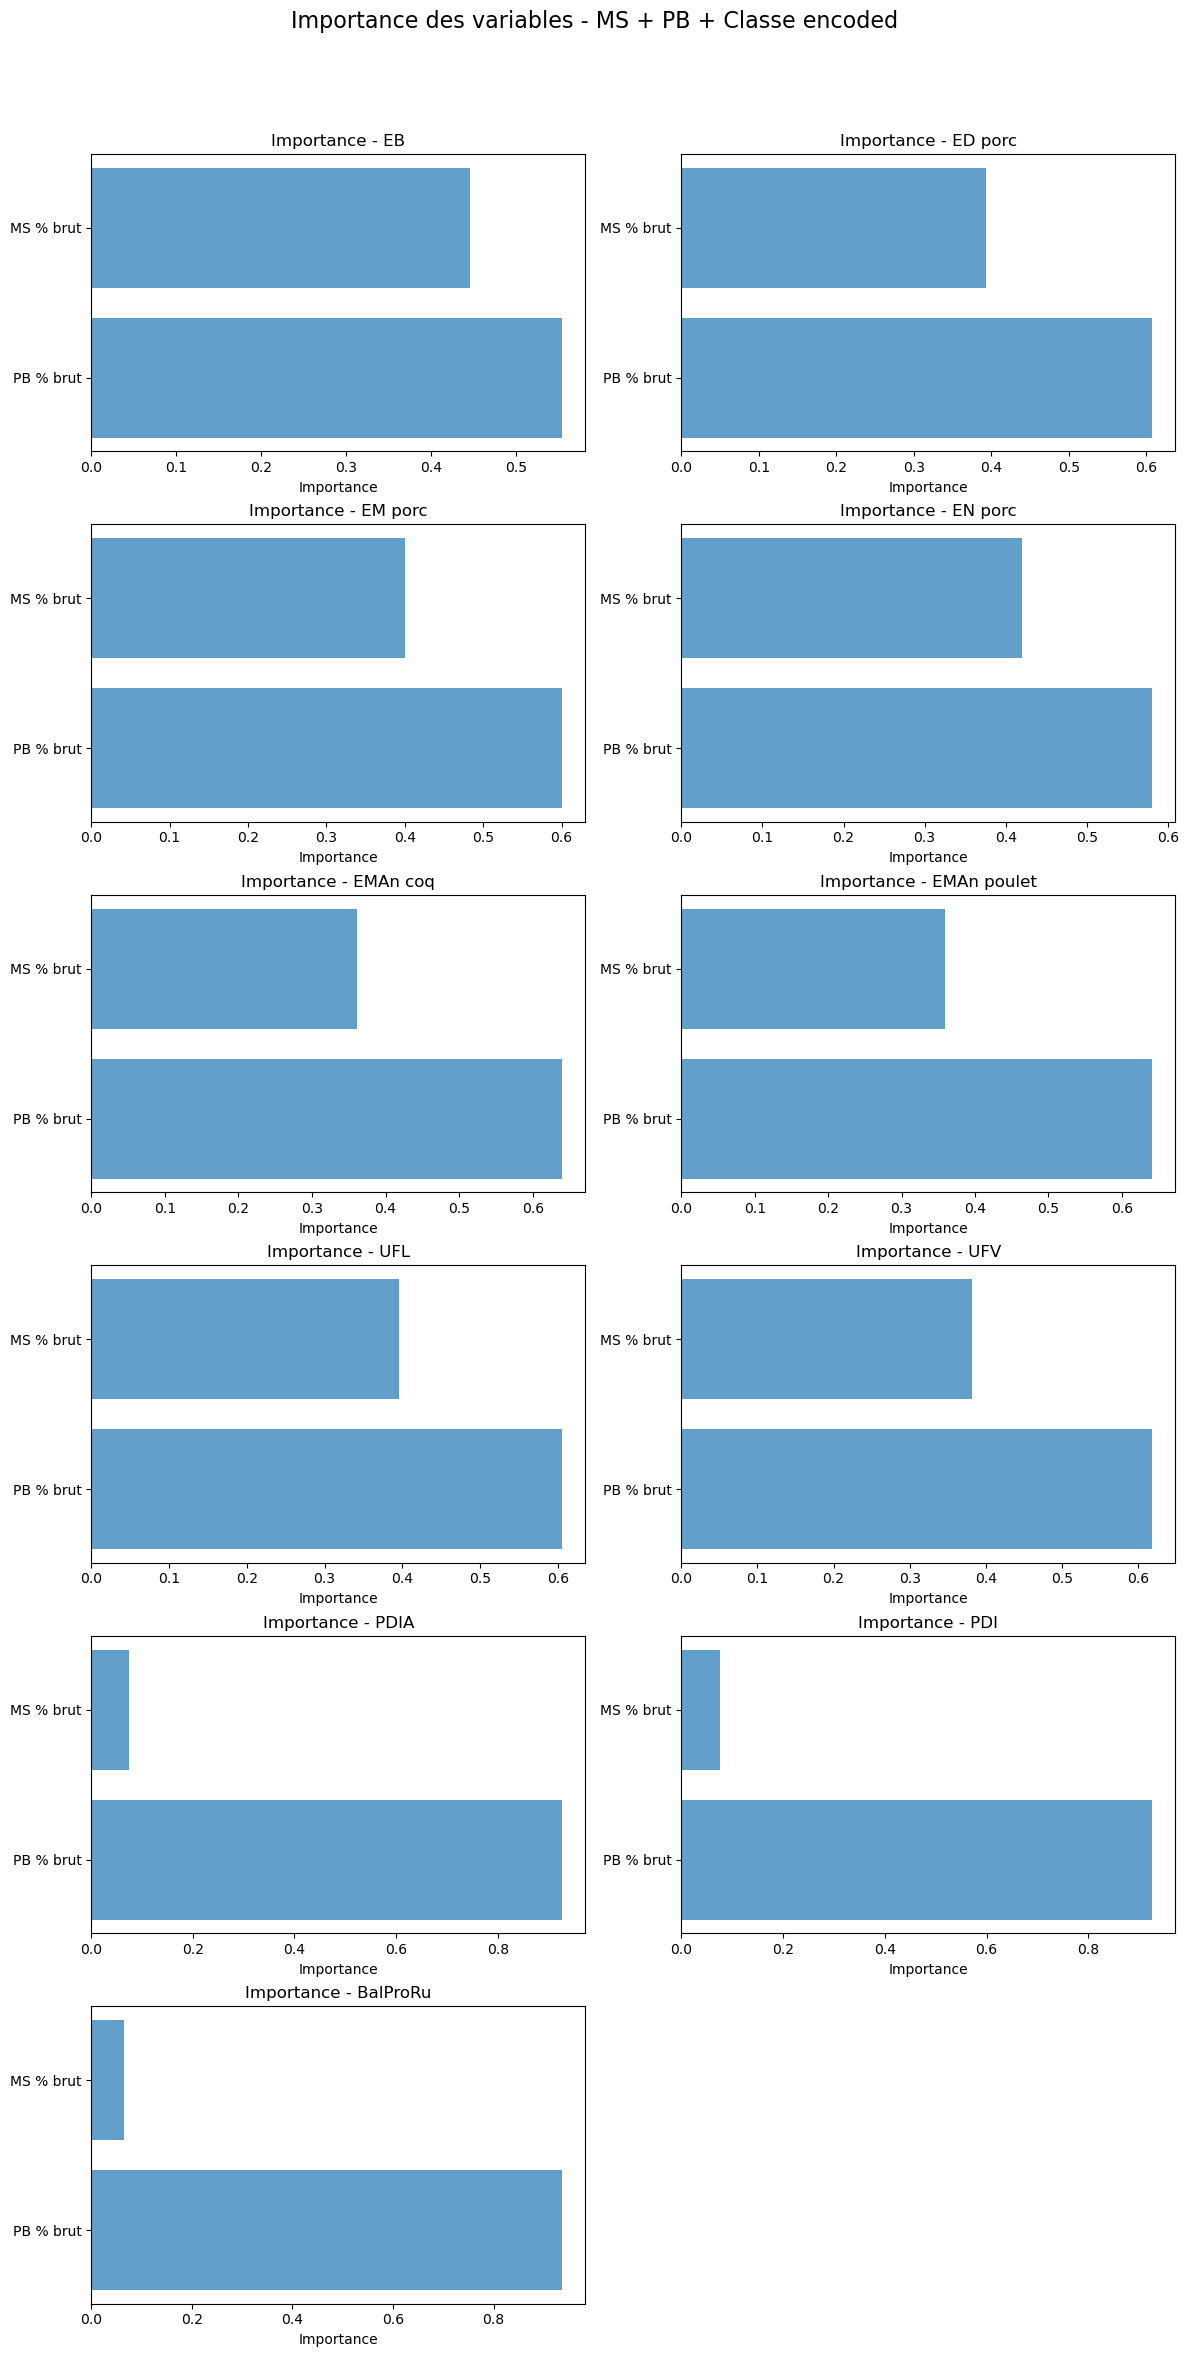

In [143]:
xgb_feature_importances(models_hide_class_sel, X_test_class_sel, vars_expl_hide_class, title="Importance des variables - MS + PB + Classe encoded")

### XGBoost Model | variables explicatives : All features
### Une Classe cachée à l'entrainement et utilisée en test uniquement pour voir l'impact sur la performance du modèle d'une nouvelle classe inconnue.

In [109]:
# Préparer les données en masquant une classe entière
# Sélectionner une classe à masquer (première classe par ordre d'apparition)
classe_a_masquer = data['Classe'].unique()[0]

# Indices train et test
indices_train_class = data[data['Classe'] != classe_a_masquer].index
indices_test_class = data[data['Classe'] == classe_a_masquer].index

X_train_class = data.loc[indices_train_class, vars_expl].copy()
y_train_class = data.loc[indices_train_class, vars_cibles].copy()

X_test_class = data.loc[indices_test_class, vars_expl].copy()
y_test_class = data.loc[indices_test_class, vars_cibles].copy()

# Entraînement des modèles
resultats_hide_class_df, metrics_hide_class, models_hide_class_all = train_xgboost_models(
    X_train_class, X_test_class, y_train_class, y_test_class, 
    vars_cibles, noms_simplifies, random_state=42
)

print(f"Classe masquée à l'entraînement: {classe_a_masquer}")
print(f"Nombre d'observations en train: {len(X_train_class)}")
print(f"Nombre d'observations en test: {len(X_test_class)}")
print()
print("Résultats du modèle avec classe entière masquée:")
print(resultats_hide_class_df.to_string(index=False))
print("\nMétriques globales:")
for key, value in metrics_hide_class.items():
    print(f"  {key}: {value}")

Classe masquée à l'entraînement: Céréales
Nombre d'observations en train: 3308
Nombre d'observations en test: 690

Résultats du modèle avec classe entière masquée:
Variable cible    MAE   RMSE      R2
            EB  53.13  62.46  0.7736
       ED porc 154.19 176.37  0.4838
       EM porc 148.62 201.53  0.3437
       EN porc  58.79  73.72  0.8990
      EMAn coq 182.36 252.67  0.2270
   EMAn poulet 225.50 288.29  0.2764
           UFL   0.05   0.06  0.2380
           UFV   0.07   0.08  0.2099
          PDIA   7.45   9.88 -0.3643
           PDI   5.59   6.80 -0.1521
      BalProRu   4.88   7.22  0.7447

Métriques globales:
  R2_uniform: 0.3345
  R2_variance_weighted: 0.4163
  R2_min: -0.3643


Variable cible  Vraie valeur  Valeur prédite
            EB       3920.00     3867.914307
       ED porc       2460.00     2384.755127
       EM porc       2380.00     2172.818115
       EN porc       1850.00     1476.214844
      EMAn coq       2610.00     1676.144287
   EMAn poulet       2480.00     1624.117798
           UFL          0.81        0.929561
           UFV          0.76        0.939088
          PDIA         17.00       26.745634
           PDI         62.00       71.406097
      BalProRu        -10.00      -13.144779


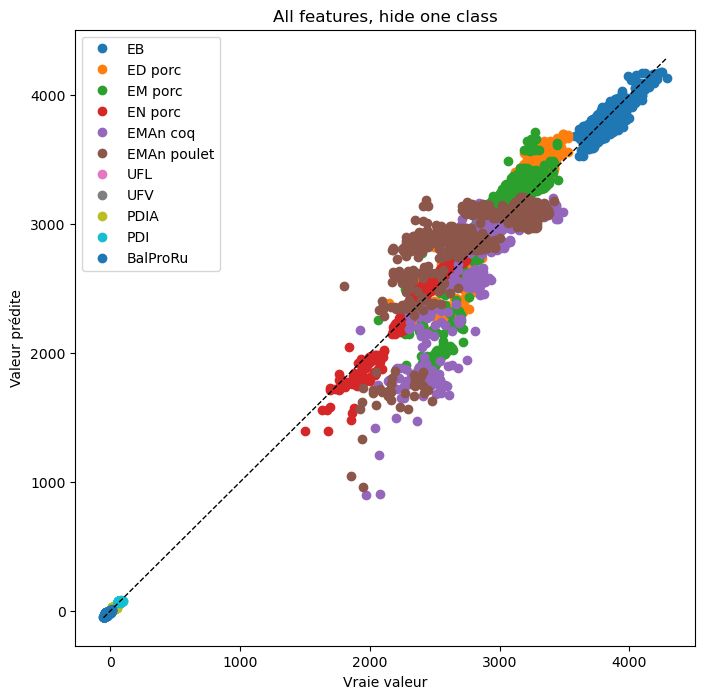

In [110]:
plot_pred_vs_true(models_hide_class_all, X_test_class, y_test_class, vars_cibles, title="All features, hide one class", n=0)

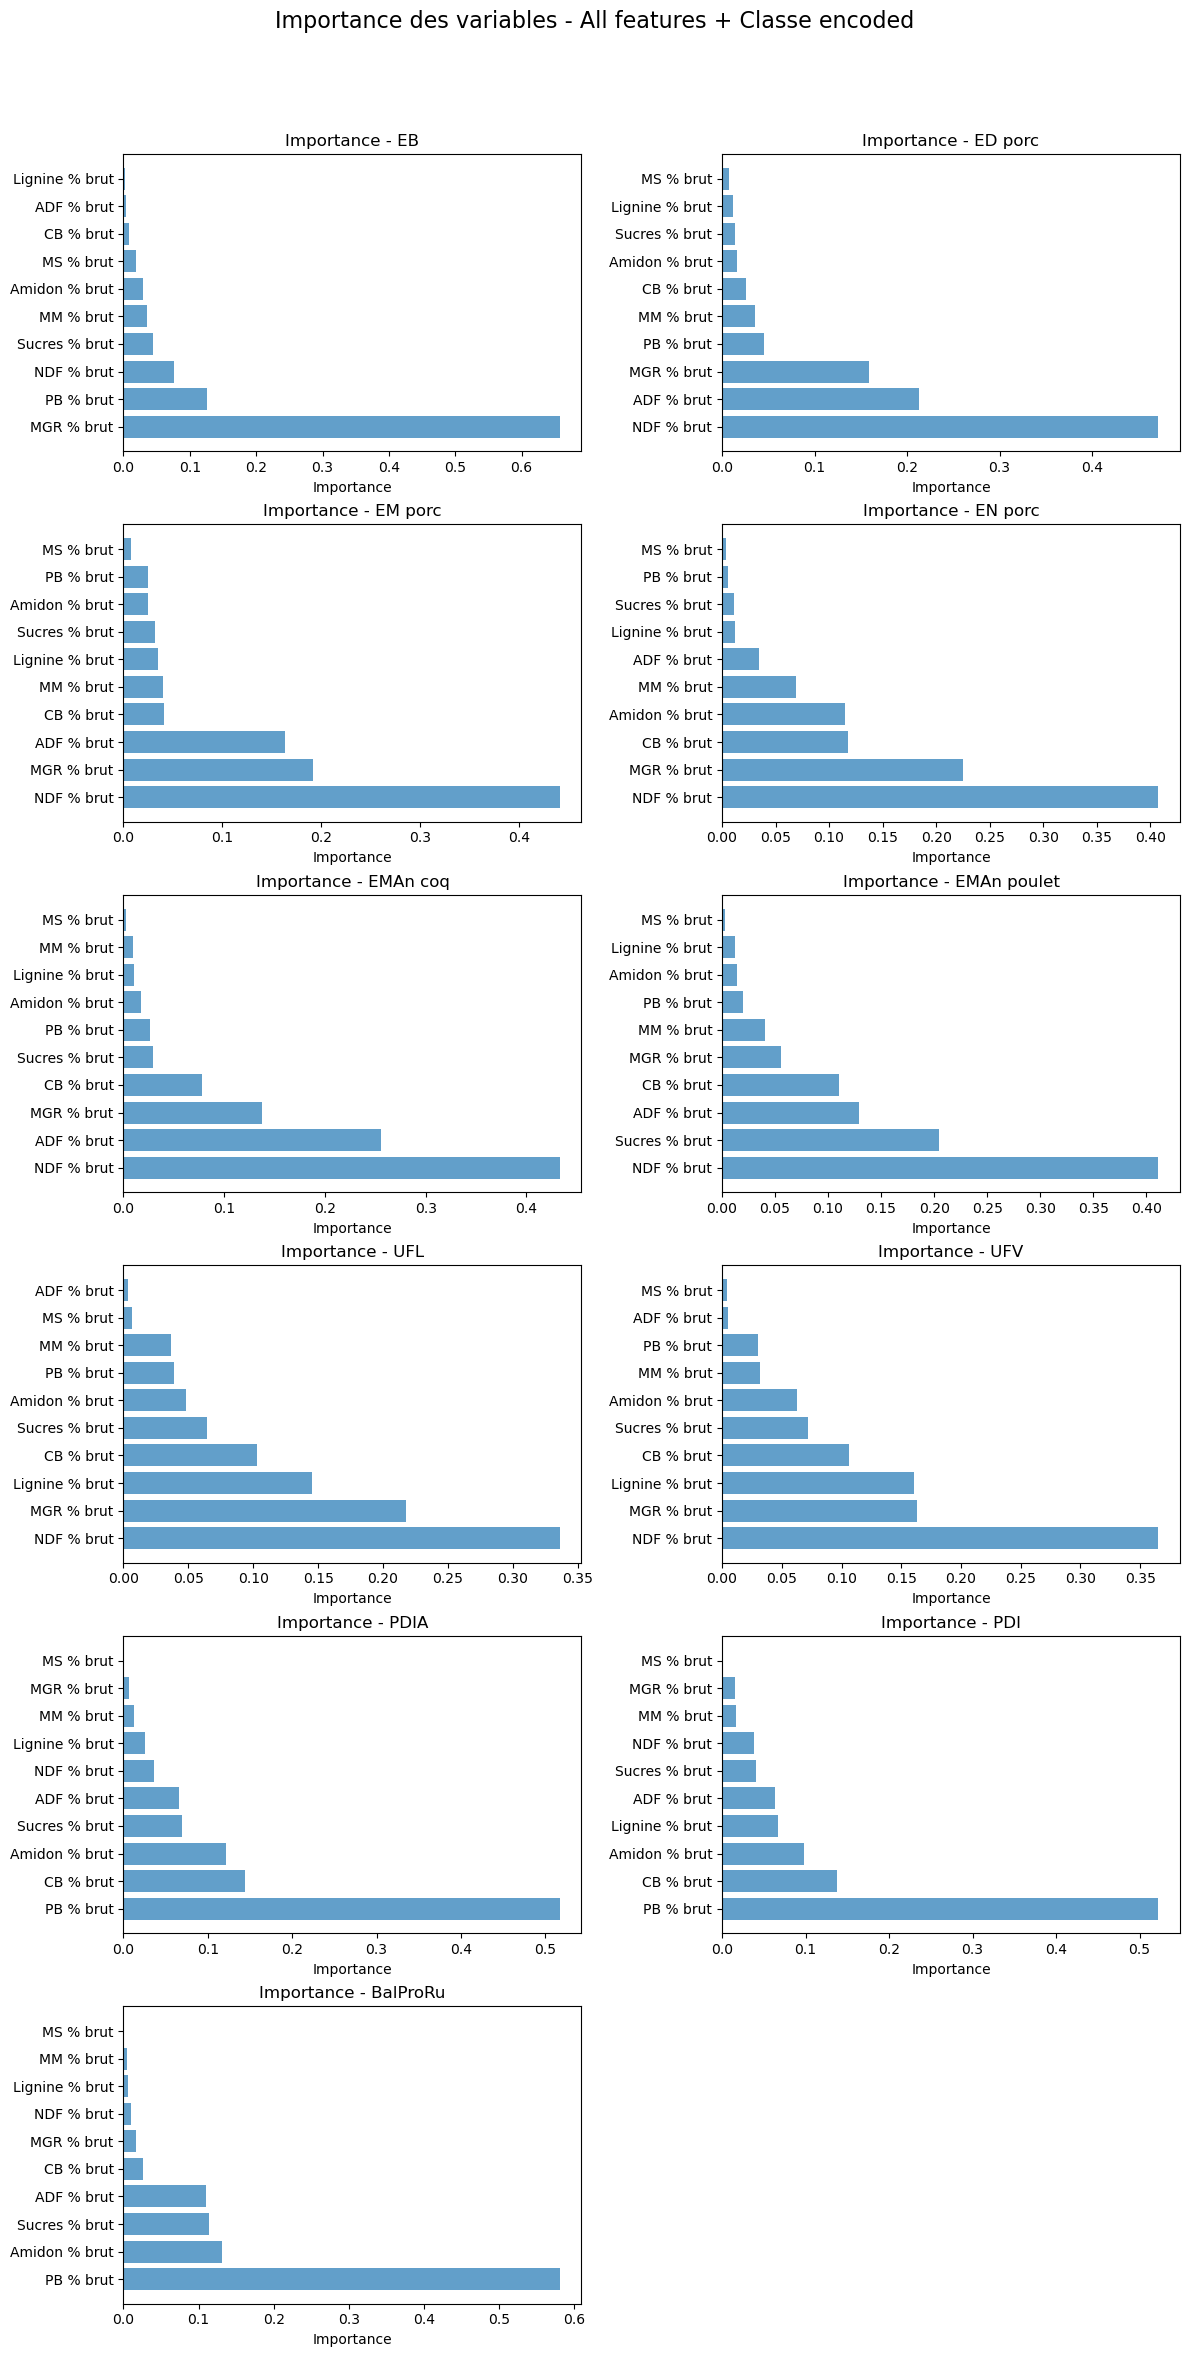

In [111]:
xgb_feature_importances(models_hide_class_all, X_test_class, vars_expl, title="Importance des variables - All features + Classe encoded")

In [166]:
# Synthèse complète des résultats de tous les modèles
synthese_resultats = pd.DataFrame({
    'Modèle': [
        'All features (comp. chim.) (Random split)',
        'All features (comp. chim.) + Classe (Random split)',
        'All features (comp. chim.) + Classe + Nom (Random split)',
        'MS + PB (Random split)',
        'MS + PB + Classe (Random split)',
        'MS + PB + Classe (Hidden products)',
        'MS + PB + Classe + Nom (Random split)',
        'All features (comp. chim.) + Classe (Hidden products)',
        'MS + PB (Hidden class)',
        'All features (comp. chim.) (Hidden class)'
    ],
    'R² variance weighted': [
        metrics_all['R2_variance_weighted'],
        metrics_all_class['R2_variance_weighted'],
        metrics_all_class_nom['R2_variance_weighted'],
        metrics_MS_PB['R2_variance_weighted'],
        metrics_MS_PB_Classe['R2_variance_weighted'],
        metrics_hide['R2_variance_weighted'],
        metrics_MS_PB_Classe_Nom['R2_variance_weighted'],
        metrics_hide_all['R2_variance_weighted'],
        metrics_hide_class_sel['R2_variance_weighted'],
        metrics_hide_class['R2_variance_weighted']
    ],
    'R² uniform': [
        metrics_all['R2_uniform'],
        metrics_all_class['R2_uniform'],
        metrics_all_class_nom['R2_uniform'],
        metrics_MS_PB['R2_uniform'],
        metrics_MS_PB_Classe['R2_uniform'],
        metrics_hide['R2_uniform'],
        metrics_MS_PB_Classe_Nom['R2_uniform'],
        metrics_hide_all['R2_uniform'],
        metrics_hide_class_sel['R2_uniform'],
        metrics_hide_class['R2_uniform']
    ],
    'Nombre obs. train': [
        len(X_train_all),
        len(X_train_all_class),
        len(X_train_all_class_nom),
        len(X_train),
        len(X_train_sel),
        len(X_train_hide),  
        len(X_train_sel_nom),
        len(X_train_hide_all), 
        len(X_train_class_sel),
        len(X_train_class)
    ],
    'Nombre obs. test': [
        len(X_test_all),
        len(X_test_all_class),
        len(X_test_all_class_nom),
        len(X_test),
        len(X_test_sel),
        len(X_test_hide),  
        len(X_test_sel_nom),
        len(X_test_hide_all),  
        len(X_test_class_sel),
        len(X_test_class)   
    ],
    'R² EB': [
        resultats_all_df[resultats_all_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_all_class_df[resultats_all_class_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_all_class_nom_df[resultats_all_class_nom_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_MS_PB_df[resultats_MS_PB_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_MS_PB_Classe_df[resultats_MS_PB_Classe_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_hide_df[resultats_hide_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_MS_PB_Classe_Nom_df[resultats_MS_PB_Classe_Nom_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_hide_all_df[resultats_hide_all_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_hide_class_sel_df[resultats_hide_class_sel_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_hide_class_df[resultats_hide_class_df['Variable cible'] == 'EB']['R2'].values[0]
    ],
    'R² ED porc': [
        resultats_all_df[resultats_all_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_all_class_df[resultats_all_class_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_all_class_nom_df[resultats_all_class_nom_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_MS_PB_df[resultats_MS_PB_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_MS_PB_Classe_df[resultats_MS_PB_Classe_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_hide_df[resultats_hide_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_MS_PB_Classe_Nom_df[resultats_MS_PB_Classe_Nom_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_hide_all_df[resultats_hide_all_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_hide_class_sel_df[resultats_hide_class_sel_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_hide_class_df[resultats_hide_class_df['Variable cible'] == 'ED porc']['R2'].values[0]
    ],
    'R² EM porc': [
        resultats_all_df[resultats_all_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_all_class_df[resultats_all_class_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_all_class_nom_df[resultats_all_class_nom_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_MS_PB_df[resultats_MS_PB_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_MS_PB_Classe_df[resultats_MS_PB_Classe_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_hide_df[resultats_hide_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_MS_PB_Classe_Nom_df[resultats_MS_PB_Classe_Nom_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_hide_all_df[resultats_hide_all_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_hide_class_sel_df[resultats_hide_class_sel_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_hide_class_df[resultats_hide_class_df['Variable cible'] == 'EM porc']['R2'].values[0]
    ],
    'R² EN porc': [
        resultats_all_df[resultats_all_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_all_class_df[resultats_all_class_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_all_class_nom_df[resultats_all_class_nom_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_MS_PB_df[resultats_MS_PB_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_MS_PB_Classe_df[resultats_MS_PB_Classe_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_hide_df[resultats_hide_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_MS_PB_Classe_Nom_df[resultats_MS_PB_Classe_Nom_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_hide_all_df[resultats_hide_all_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_hide_class_sel_df[resultats_hide_class_sel_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_hide_class_df[resultats_hide_class_df['Variable cible'] == 'EN porc']['R2'].values[0]
    ]
})

print("=" * 160)
print("SYNTHÈSE COMPLÈTE DES RÉSULTATS")
print("=" * 160)
print(synthese_resultats.sort_values(by='R² variance weighted', ascending=False).to_string(index=False))
print()

SYNTHÈSE COMPLÈTE DES RÉSULTATS
                                                  Modèle  R² variance weighted  R² uniform  Nombre obs. train  Nombre obs. test   R² EB  R² ED porc  R² EM porc  R² EN porc
All features (comp. chim.) + Classe + Nom (Random split)                0.9936      0.9937               3198               800  0.9935      0.9917      0.9917      0.9960
      All features (comp. chim.) + Classe (Random split)                0.9928      0.9927               3198               800  0.9930      0.9887      0.9912      0.9953
               All features (comp. chim.) (Random split)                0.9927      0.9922               3198               800  0.9930      0.9917      0.9896      0.9950
                   MS + PB + Classe + Nom (Random split)                0.9598      0.9658               3198               800  0.9669      0.9449      0.9435      0.9552
                         MS + PB + Classe (Random split)                0.8661      0.8912               319

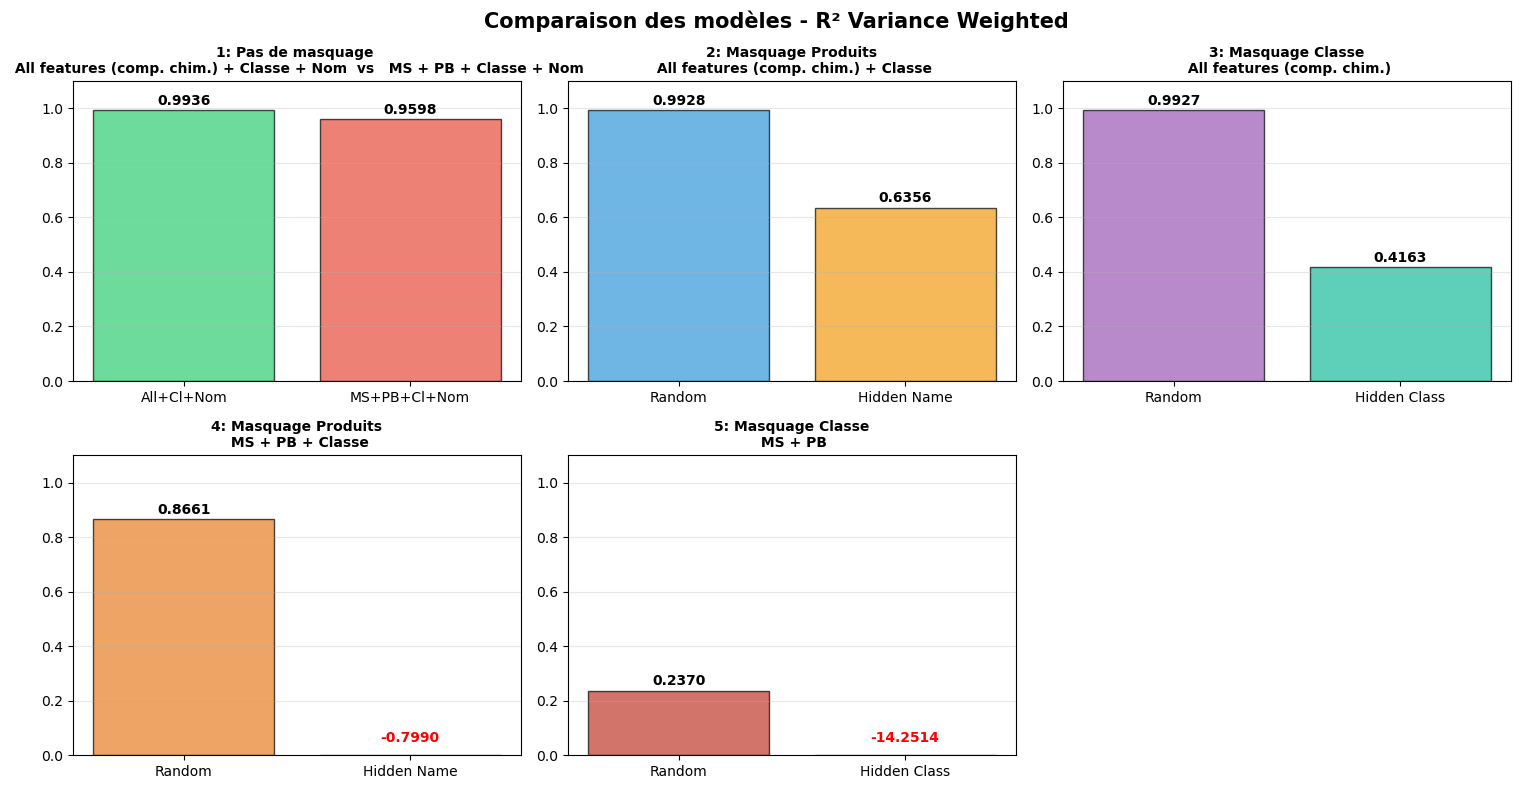

In [ ]:
import matplotlib.pyplot as plt

comparaisons = [
    ("1: Pas de masquage \n All features (comp. chim.) + Classe + Nom  vs   MS + PB + Classe + Nom", ['All+Cl+Nom', 'MS+PB+Cl+Nom'], 
     [metrics_all_class_nom['R2_variance_weighted'], metrics_MS_PB_Classe_Nom['R2_variance_weighted']], ['#2ecc71', '#e74c3c']),
    
    ("2: Masquage Produits\n All features (comp. chim.) + Classe", ['Random', 'Hidden Name'], 
     [metrics_all_class['R2_variance_weighted'], metrics_hide_all['R2_variance_weighted']], ['#3498db', '#f39c12']),
    
    ("3: Masquage Classe\n All features (comp. chim.)", ['Random', 'Hidden Class'], 
     [metrics_all['R2_variance_weighted'], metrics_hide_class['R2_variance_weighted']], ['#9b59b6', '#1abc9c']),
    
    ("4: Masquage Produits\n MS + PB + Classe", ['Random', 'Hidden Name'], 
     [metrics_MS_PB_Classe['R2_variance_weighted'], metrics_hide['R2_variance_weighted']], ['#e67e22', '#16a085']),
    
    ("5: Masquage Classe\n MS + PB", ['Random', 'Hidden Class'], 
     [metrics_MS_PB['R2_variance_weighted'], metrics_hide_class_sel['R2_variance_weighted']], ['#c0392b', '#2980b9'])
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Comparaison des modèles - R² Variance Weighted', fontsize=15, fontweight='bold')

axes_flat = axes.flatten()

for i, (title, labels, values, colors) in enumerate(comparaisons):
    ax = axes_flat[i]
    bars = ax.bar(labels, values, color=colors, alpha=0.7, edgecolor='black')
    
    ax.set_title(title, fontsize=10, fontweight='bold')
    
    ax.set_ylim(0, 1.1)
    
    ax.grid(axis='y', alpha=0.3)
    
    for b in bars:
        val = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, 0.05 if val < 0 else val + 0.02, 
                f'{val:.4f}', ha='center', fontweight='bold', color='red' if val < 0 else 'black')

axes_flat[-1].axis('off')

plt.tight_layout()
plt.show()

## Analyse des SHAP values pour le modèle avec toutes les features et variables catégorielles encodées

Modèle pour la variable cible: EB


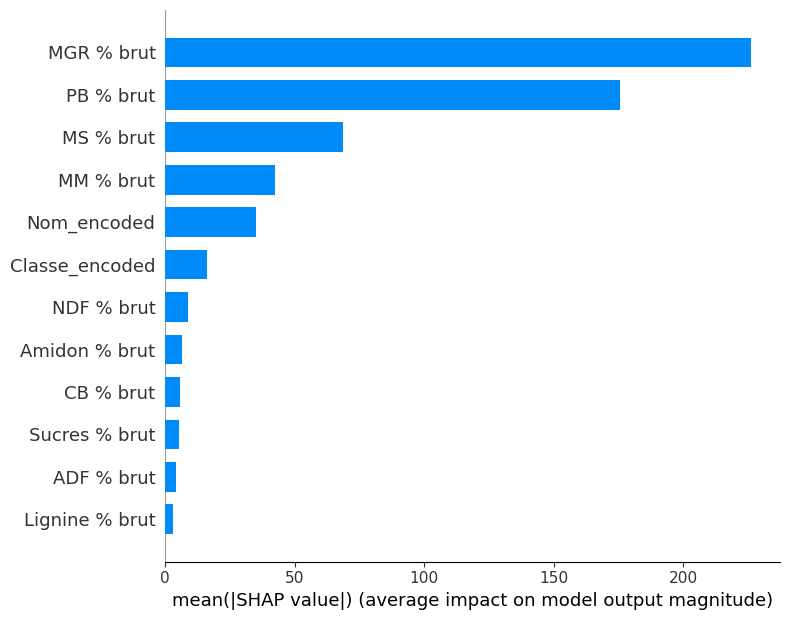

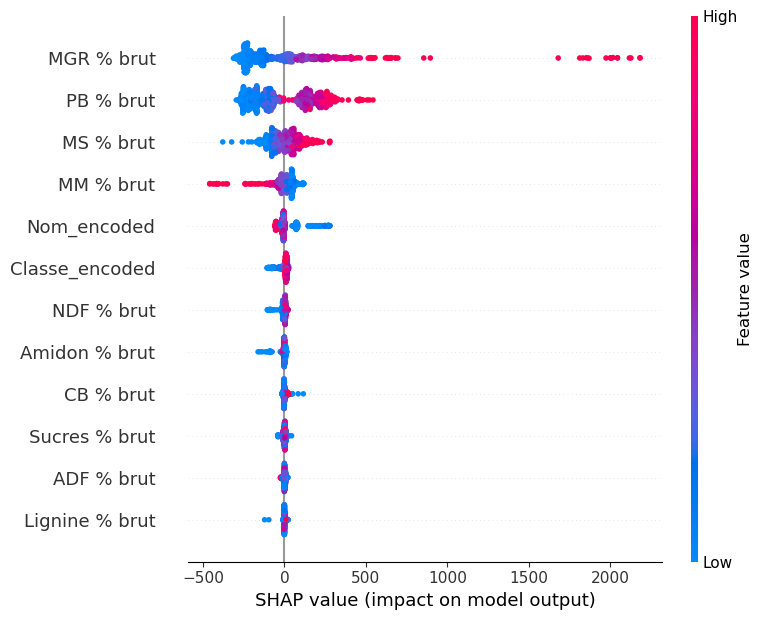

Modèle pour la variable cible: ED porc


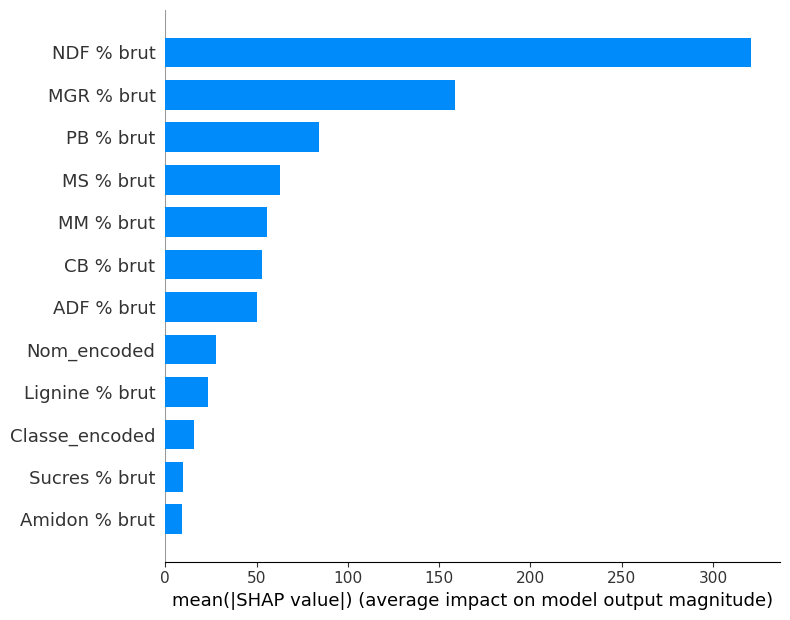

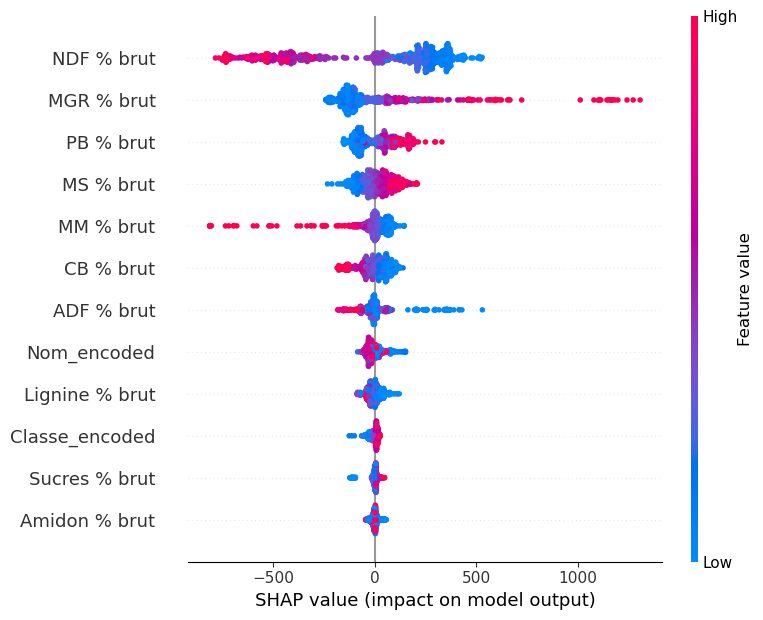

Modèle pour la variable cible: EM porc


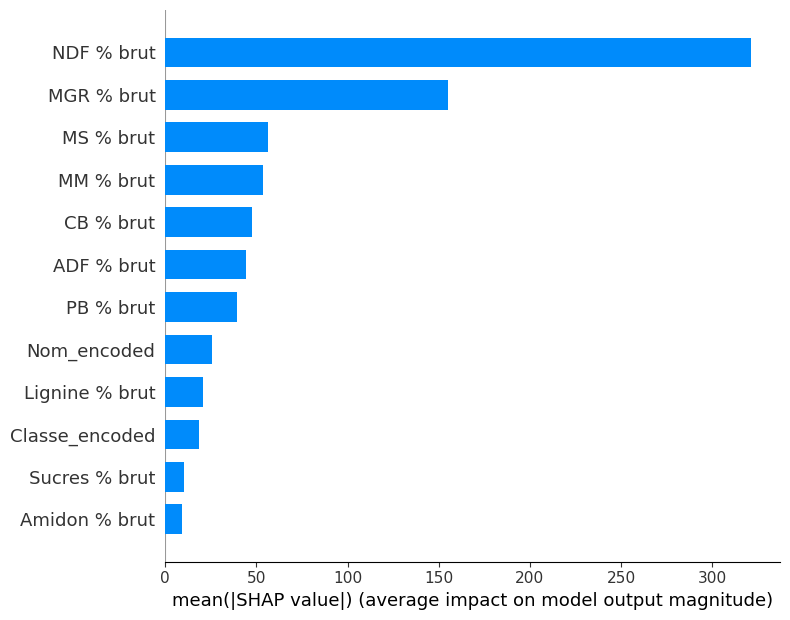

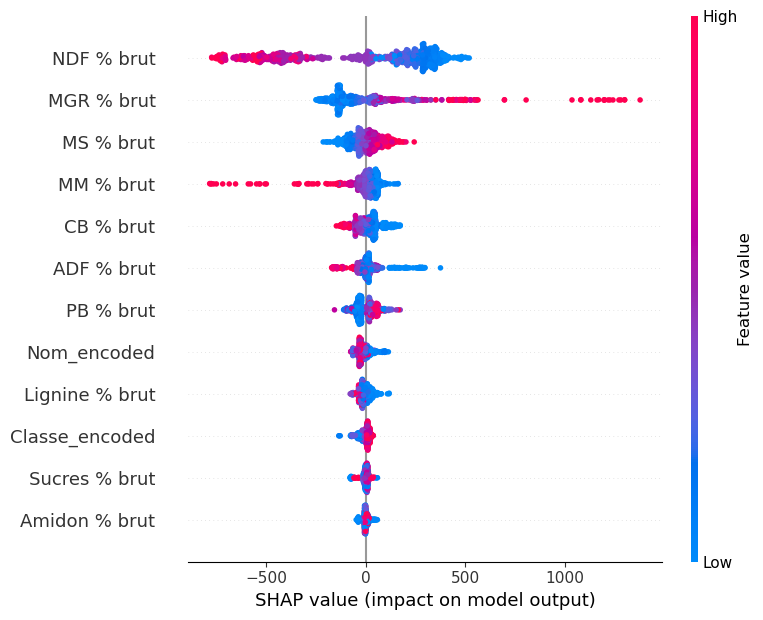

Modèle pour la variable cible: EN porc


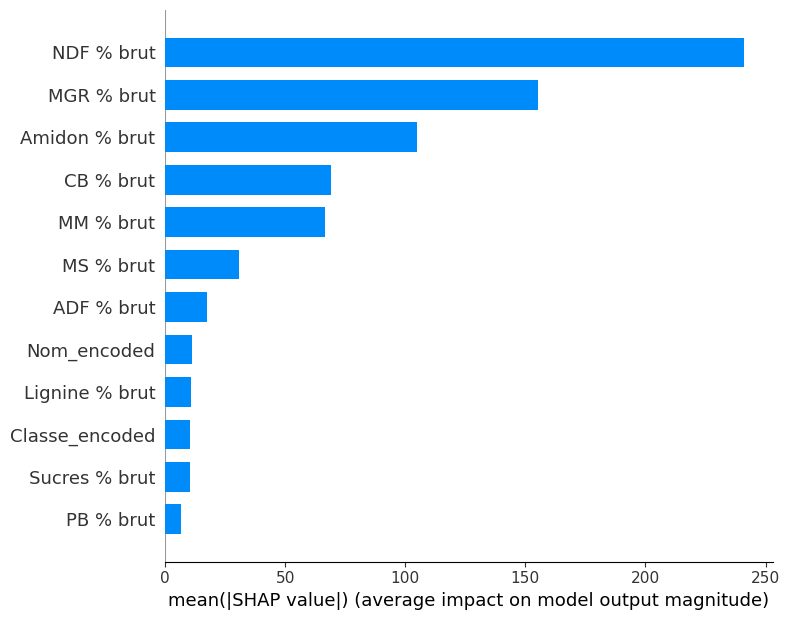

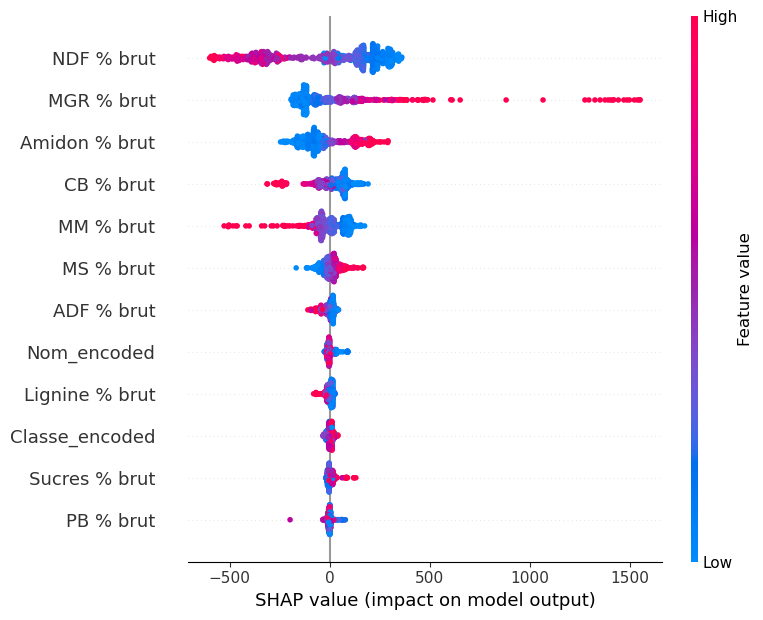

In [116]:
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

X_train_shap = X_train_all.copy()
X_test_shap = X_test_all.copy()

# Ajouter Nom et Classe encodée
le = LabelEncoder()
le.fit(data['Nom'].values)
X_train_shap['Nom_encoded'] = le.transform(data.loc[X_train_all.index, 'Nom'].values)
X_test_shap['Nom_encoded'] = le.transform(data.loc[X_test_all.index, 'Nom'].values)

le_classe = LabelEncoder()
le_classe.fit(data['Classe'].values)
X_train_shap['Classe_encoded'] = le_classe.transform(data.loc[X_train_all.index, 'Classe'].values)
X_test_shap['Classe_encoded'] = le_classe.transform(data.loc[X_test_all.index, 'Classe'].values)

df_perf, metrics_shap, models_dict = train_xgboost_models(
    X_train_shap, X_test_shap, y_train_all, y_test_all, 
    vars_cibles, noms_simplifies
)

# Visualisations SHAP
for target in vars_cibles[:4]: 
    print(f"Modèle pour la variable cible: {noms_simplifies[target]}")
    model = models_dict[target]

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_shap)

    # --- VISUALISATION 1 : Importance Globale ---
    shap.summary_plot(shap_values, X_test_shap, plot_type="bar")

    # --- VISUALISATION 2 : Impact et Distribution (Beeswarm) ---
    shap.summary_plot(shap_values, X_test_shap)